# Import

In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from scipy.signal import detrend as scipy_detrend
from sklearn.linear_model import LinearRegression
import regionmask
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import make_scorer

# Load

In [2]:
ds = xr.open_dataset('data/spi3_cmap_1x1.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

spi = spi.sel(time=slice('1981-01-01', '2020-12-31'))

# Fig1 - Trend

In [3]:
def mk_test(x):
    x = x[~np.isnan(x)]
    if len(x) < 3:
        return np.array([np.nan, np.nan])
    result = mk.original_test(x)
    trend_value = result.slope  # numeric trend (Sen's slope)
    sig = int(result.p <= 0.10)
    return np.array([trend_value, sig])

In [4]:
month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}


In [5]:
months = np.arange(1, 13)
season_labels = [month_to_season[m] for m in months]

trend_list = []
sig_list = []

for month in months:
    print(f"Processing month {month} : {month_to_season[month]}")

    spi_pre = spi.sel(time=slice('1981-01-01', '2000-12-31'))
    spi_post = spi.sel(time=slice('2001-01-01', '2020-12-31'))
    
    spi_month = spi.sel(time=spi['time'].dt.month == month)
    
    trend_sig = xr.apply_ufunc(
        mk_test,
        spi_month,
        input_core_dims=[['time']],
        output_core_dims=[['metric']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    trend = trend_sig.sel(metric=0)
    sig = trend_sig.sel(metric=1)
    
    trend_list.append(trend)
    sig_list.append(sig)


Processing month 1 : NDJ
Processing month 2 : DJF
Processing month 3 : JFM
Processing month 4 : FMA
Processing month 5 : MAM
Processing month 6 : AMJ
Processing month 7 : MJJ
Processing month 8 : JJA
Processing month 9 : JAS
Processing month 10 : ASO
Processing month 11 : SON
Processing month 12 : OND


In [6]:
trend_seasonal = xr.concat(trend_list, dim='season')
sig_seasonal = xr.concat(sig_list, dim='season')
trend_seasonal['season'] = season_labels
sig_seasonal['season'] = season_labels

selected_seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
trend_subset = trend_seasonal.sel(season=selected_seasons)
sig_subset = sig_seasonal.sel(season=selected_seasons)


C:\Users\emile\AppData\Local\Temp\ipykernel_15216\413871298.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local\Temp\ipykernel_15216\413871298.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local\Temp\ipykernel_15216\413871298.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local\Te

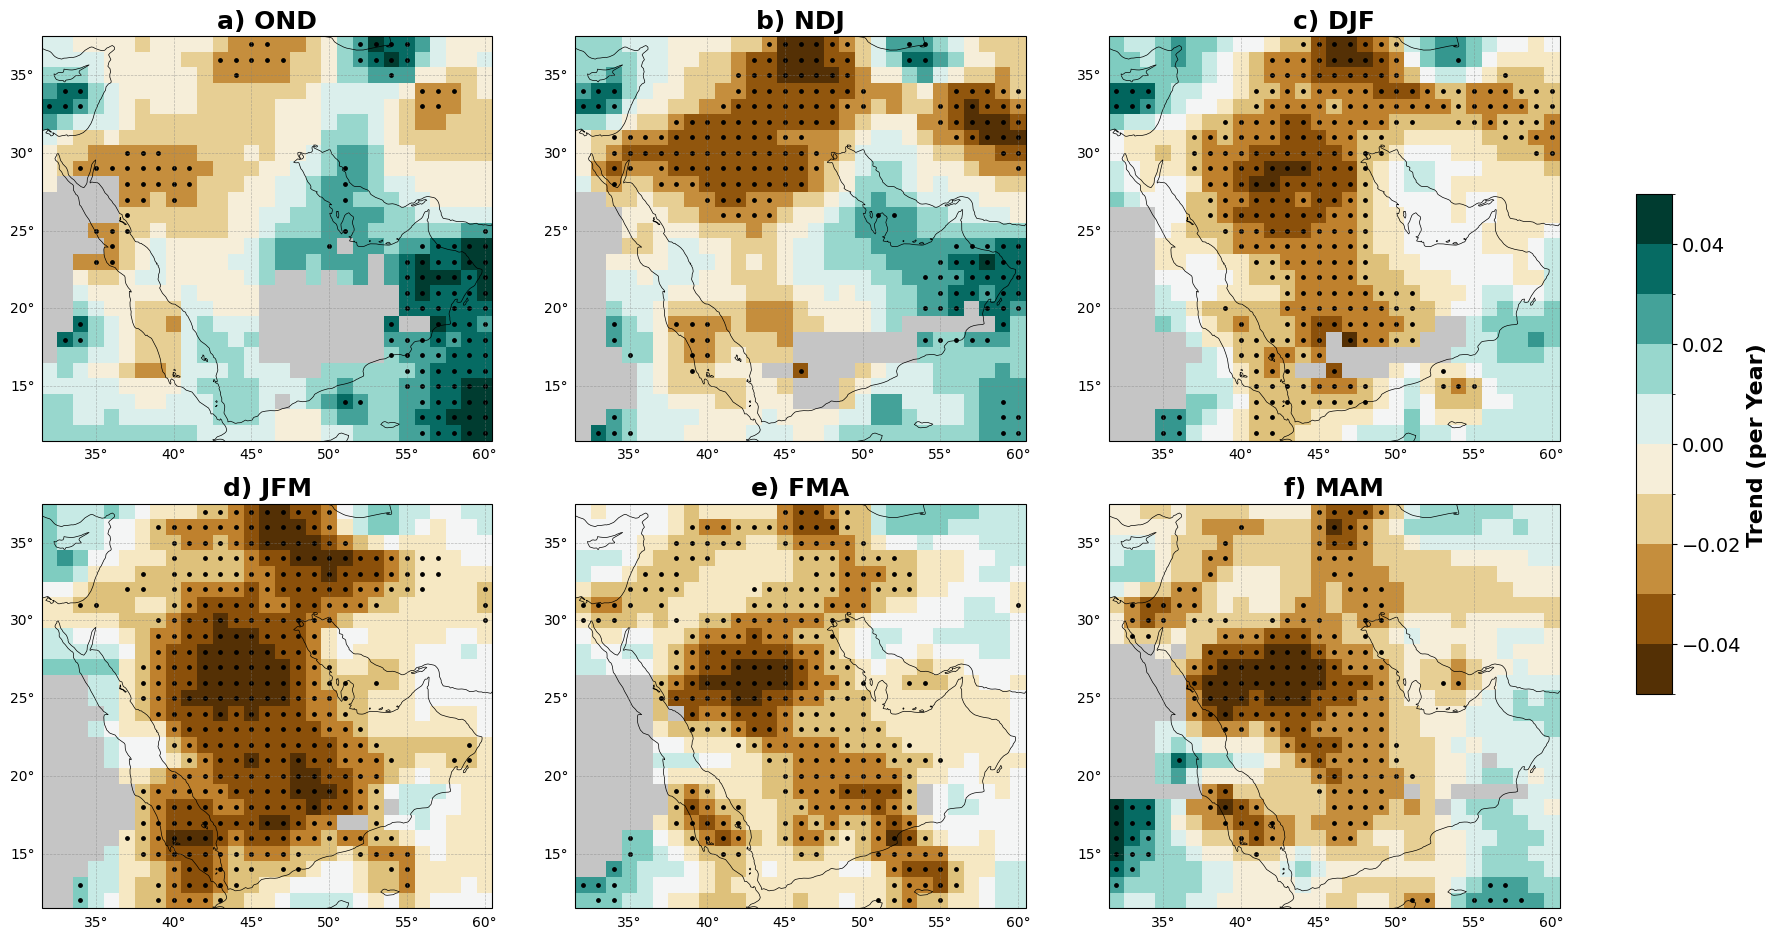

In [7]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

# Labels to prefix the season titles
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, ax in enumerate(axes):
    if i < len(selected_seasons):
        season = selected_seasons[i]
        tr = trend_subset.sel(season=season)
        sig = sig_subset.sel(season=season)
        brbg = cm.get_cmap('BrBG', 256)
        brbg = mcolors.ListedColormap(brbg(np.linspace(0, 1, 256)))
        brbg.set_bad('gray',alpha=0.45)

        pcm = tr.plot.pcolormesh(
            ax=ax,
            cmap=brbg,
            vmin=-0.05, vmax=0.05, levels=11,
            add_colorbar=False,
            transform=ccrs.PlateCarree()
        )

        y_coords, x_coords = np.where(sig.values == 1)
        lats = tr['lat'].values[y_coords]
        lons = tr['lon'].values[x_coords]
        ax.scatter(lons, lats, color='k', s=6, transform=ccrs.PlateCarree())

        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

        # Add a), b), etc. before the season name
        ax.set_title(f"{labels[i]} {season}", fontsize=18, fontweight='bold')

        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.bottom_labels = True

        gl.xformatter = mticker.FuncFormatter(lambda x, pos: f"{int(x)}°")
        gl.yformatter = mticker.FuncFormatter(lambda y, pos: f"{int(y)}°")

    else:
        ax.axis('off')

# Add a larger colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(pcm, cax=cbar_ax, label='Trend (per Year)', orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(16)
cbar.ax.yaxis.label.set_weight('bold')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('figures/part1figs/fig1_trend.pdf', dpi=300)
plt.show()


# Fig 2 - Density

In [8]:
periods = {
    '1981-2000': slice('1981-01-01', '2000-12-31'),
    '2001-2020': slice('2001-01-01', '2020-12-31'),
    '1981-2020': slice('1981-01-01', '2020-12-31')
}

month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}

seasons = selected_seasons


# Container: season → period → flattened SPI values
data_for_plot = {season: {} for season in seasons}

for season_idx, season in enumerate(seasons, 1):
    # Select data for this season (month)
    spi_season = spi.sel(time=spi['time'].dt.month == season_idx)

    for period_name, time_slice in periods.items():
        spi_period = spi_season.sel(time=time_slice).mean(['time'])

        # Flatten all grid cells and times for KDE
        values = spi_period.values.flatten()
        values = values[~np.isnan(values)]

        data_for_plot[season][period_name] = values


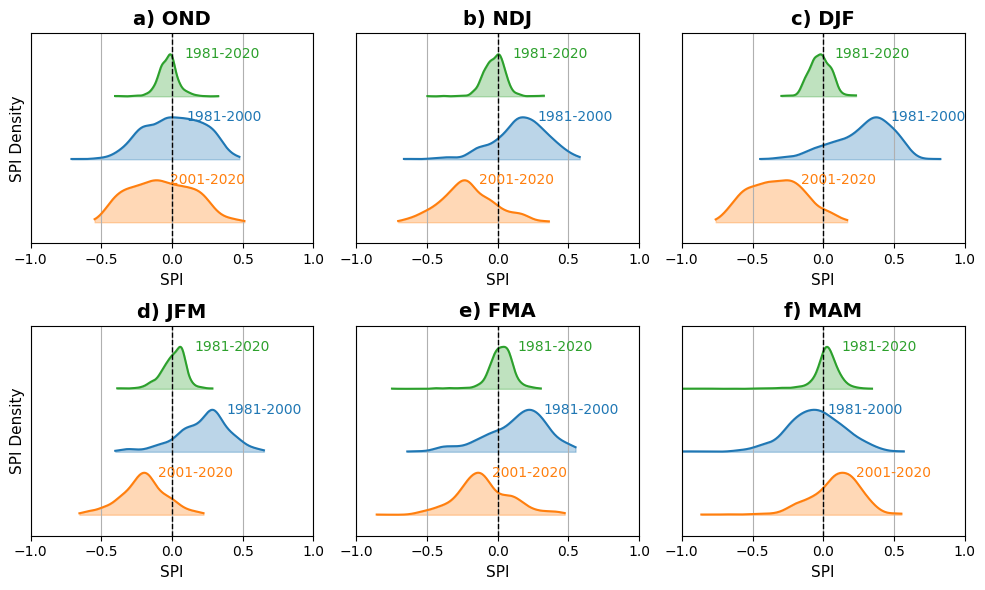

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# New periods order and colors with reversed vertical order for plotting
periods_order = ['1981-2020', '1981-2000', '2001-2020']
colors = ['tab:green', 'tab:blue', 'tab:orange']
offsets = [3, 1.5, 0]

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, season in enumerate(selected_seasons):
    ax = axes[i]
    max_density = 0
    
    for offset, period_name, color in zip(offsets, periods_order, colors):
        data = data_for_plot[season][period_name]
        
        if len(data) < 10:
            continue
        
        kde = gaussian_kde(data)
        xs = np.linspace(np.min(data), np.max(data), 200)
        ys = kde(xs)
        ys_scaled = ys / ys.max() + offset
        
        ax.plot(xs, ys_scaled, color=color)
        ax.fill_between(xs, offset, ys_scaled, color=color, alpha=0.3)
        
        # Add period label inside the plot next to the right end of the KDE
        x_text = xs[np.argmax(ys_scaled)] + 0.1
        y_text = ys_scaled[np.argmax(ys_scaled)]
        ax.text(x_text, y_text, period_name, color=color, fontsize=10, va='center')

        max_density = max(max_density, ys_scaled.max())

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    
    ax.set_yticks([])  # remove y-axis labels completely
    ax.set_ylim(-0.5, max_density + 0.5)
    ax.set_xlabel('SPI', fontsize=11)
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    ax.grid(True, axis='x')

    ax.set_xlim(-1, 1)
    
    if i % 3 == 0:
        ax.set_ylabel('SPI Density', fontsize=11)

# Turn off unused axes
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/part1figs/fig2_kde.pdf', dpi=300)
plt.show()

# Suppl. Fig 1

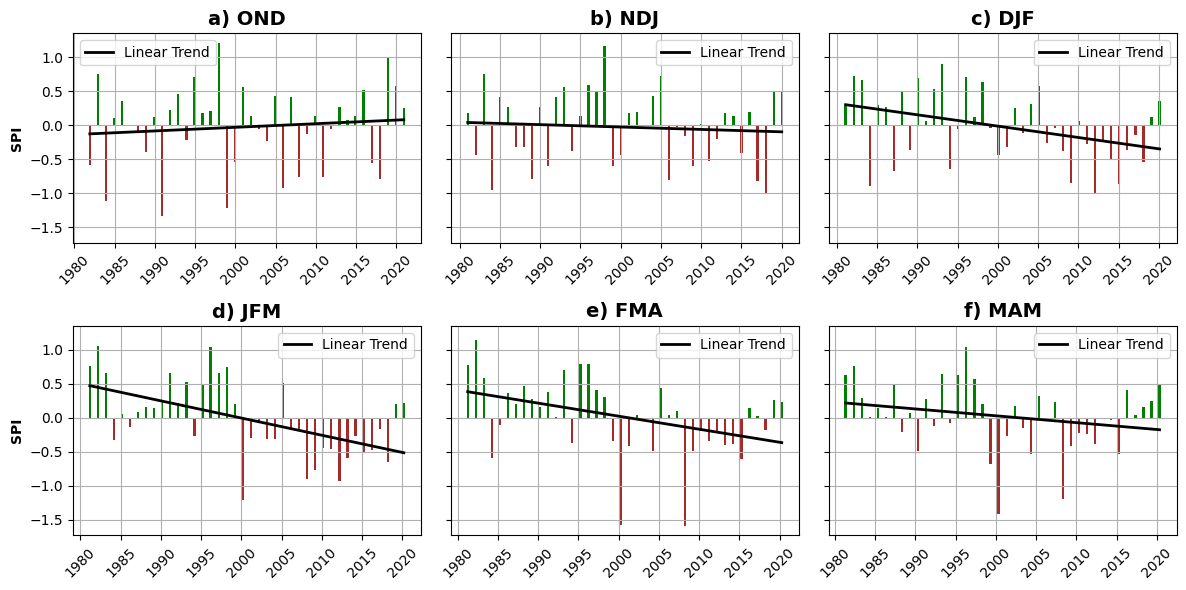

In [10]:
# Your selected seasons (replace with your actual 6 selected seasons)
selected_seasons = ['OND', 'NDJ','DJF', 'JFM', 'FMA', 'MAM']

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.flatten()

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']  # Label prefixes

for i, season in enumerate(selected_seasons):
    ax = axes[i]
    
    # month_to_season mapping
    month_to_season = {
        1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
        5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
        9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
    }
    
    # Get months for the current season
    months_in_season = [m for m, s in month_to_season.items() if s == season]
    
    # Filter spi data for these months
    spi_season = spi.sel(time=spi['time'].dt.month.isin(months_in_season))
    
    # Compute spatial average over domain for selected months & times
    spi_avg = spi_season.mean(dim=['lat', 'lon'])
    
    times = pd.to_datetime(spi_avg['time'].values)
    values = spi_avg.values
    
    # Linear regression
    time_numeric = np.arange(len(times))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, values)
    trend_line = intercept + slope * time_numeric
    
    # Bar colors by sign
    colors = ['green' if v > 0 else 'brown' for v in values]
    
    # Plot bars and trend
    ax.bar(times, values, color=colors, width=100, align='center')
    ax.plot(times, trend_line, color='black', linewidth=2, label='Linear Trend')
    
    # Title with prefix label
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    
    if i % 3 == 0:
        ax.set_ylabel('SPI',fontweight='bold')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45, labelsize=10)

# Hide unused axes if any
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/part1figs/suppfig_ts_bar.pdf', dpi=300)
plt.show()

# Fig 3 Teleco SST

In [11]:

#NOAA COBE SST data
sst = xr.open_dataset('data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))
#select enso region
sst = sst.sel(lat=slice(30, -30), lon=slice(140, 290))


In [16]:
def svd_analysis(left, right, n_modes=1, month=None, label=None, left_var="SST", right_var='SPI',
                 left_proj=ccrs.PlateCarree(central_longitude=150), right_proj = ccrs.PlateCarree(), detrend=False):


    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        left = left.sel(time=left['time.month'] == month_num)
        right = right.sel(time=right['time.month'] == month_num)
    right_mask = right.isel(time=0).notnull().values

    if detrend:
        def xr_detrend(da):
            return xr.apply_ufunc(
                scipy_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[da.dtype]
            )
        left = xr_detrend(left.fillna(0)).transpose('time','lat','lon')
        right = xr_detrend(right.fillna(0)).transpose('time','lat','lon')

    left = (left - left.mean(dim='time', skipna=True)) / (left.std(dim='time', skipna=True) + 1e-6)
    right = (right - right.mean(dim='time', skipna=True)) / (right.std(dim='time', skipna=True) + 1e-6)

    mca = xMCA(left.fillna(0), right.fillna(0))
    mca.apply_coslat()
    mca.solve()


    X = left.fillna(0)
    Y = right.fillna(0)



    if month is not None:
        mca.set_field_names(f'{left_var} ({month})', f'{right_var} ({month})')
    else:
        mca.set_field_names({left_var}, {right_var})

    table = []
    for i in range(n_modes):
        fig = plt.figure(figsize=(18, 6))

                # Rank-1 reconstructions
        X_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['left']
        Y_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['right']

        # Total and explained variance
        total_var_X = np.sum(np.var(X, axis=0, ddof=1))
        total_var_Y = np.sum(np.var(Y, axis=0, ddof=1))
        explained_var_X = np.sum(np.var(X_recon, axis=0, ddof=1))
        explained_var_Y = np.sum(np.var(Y_recon, axis=0, ddof=1))

        frac_var_left = explained_var_X / total_var_X
        frac_var_right = explained_var_Y / total_var_Y


        left_map = mca.eofs()['left'].sel(mode=i+1)
        right_map = mca.eofs()['right'].sel(mode=i+1)
        right_map = right_map.where(right_mask)

        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()
        r_val = np.corrcoef(left_pcs.values, right_pcs.values)[0, 1]

                # Use PCs
        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)

        # Normalize PCs
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()

        # Align time for correlation
        left = left.sel(time=left_pcs['time'])
        right = right.sel(time=right_pcs['time'])

        # Grid-wise correlation between PC and gridcell time series
        def correlate_grid(grid_data, pc):
            # Assume grid_data has shape (time, lat, lon)
            corr = xr.corr(grid_data, pc, dim='time')
            return corr

        # These are the spatial correlation maps now
        left_map = correlate_grid(left, right_pcs)
        right_map = correlate_grid(right, left_pcs)

        # Mask invalid areas
        right_map = right_map.where(right_mask)
        left_map = left_map.where(~np.isnan(left.isel(time=0)))
        right_map = right_map.where(~np.isnan(right.isel(time=0)))

        explained_covar = mca.explained_variance()[i] / 100

        nino_lat_bounds = (5, -5)     # Latitude bounds
        nino_lon_bounds = (170, 240)  # Longitude bounds in 0-360



        # Subset and compute average anomaly over Nino3.4 region
        nino34_anom = left_map.sel(
        lon=slice(nino_lon_bounds[0], nino_lon_bounds[1]),
        lat=slice(nino_lat_bounds[0], nino_lat_bounds[1]))
        

        # Take the mean over time (or specific month if already selected)
        mean_nino34 = nino34_anom.mean()

        # Conditionally flip the sign based on Nino3.4 anomaly
        if mean_nino34 < 0 and left_var == 'SST':
            left_map = -left_map
            right_map = -right_map
            left_pcs = -left_pcs
            right_pcs = -right_pcs
        
        # NAO bounds western africa
        nao_lat_bounds = (20, 0)
        nao_lon_bounds = (-20, 20) 

        # Subset and compute average anomaly over NAO region
        nao_anom = left_map.sel(
        lon=slice(nao_lon_bounds[0], nao_lon_bounds[1]),
        lat=slice(nao_lat_bounds[0], nao_lat_bounds[1]))

        # Take the mean over time (or specific month if already selected)
        mean_nao = nao_anom.mean()

        # Conditionally flip the sign based on NAO anomaly
        if mean_nao <0 and left_var == 'SLP':
             left_map = -left_map
             right_map = -right_map
             left_pcs = -left_pcs
             right_pcs = -right_pcs

        #print table with explaine covariance and explaine variance and pc time series correlation

        #print(f"Mode {i+1}:")
        #print(f"Explained Variance {left_var}: {frac_var_left:.2%}")
        #print(f"Explained Variance {right_var}: {frac_var_right:.2%}")
        #print(f"Pearson r between PCs: {r_val:.2f}\n")
        #print(f"Explained Covariance: {explained_covar:.1%}\n")

        #save these values in a table

        table.append([i+1, np.round(100*frac_var_left.values,1), np.round(100*frac_var_right.values,1),
                       np.round(r_val,2), np.round(explained_covar.values*100,1)])

        cbar_ticks = [-0.6,-0.5,-0.4, -0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

        cmap_discrete = plt.get_cmap('RdBu_r', len(cbar_ticks)-1)

        #apply nan mask to left_map and right_map
        left_map = left_map.where(~np.isnan(left.isel(time=0)).values)
        right_map = right_map.where(~np.isnan(right.isel(time=0)).values)



        ax1 = fig.add_subplot(1, 3, 1, projection=left_proj)
        pcm1 = ax1.pcolormesh(
            left_map['lon'], left_map['lat'], left_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete, 
            vmin=-0.6, vmax=0.6
        )
        ax1.coastlines()
        cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar1.set_label(f"{left_var} Corr. - Expl. Var. {frac_var_left:.1%}", fontsize=14, fontweight='bold')
        cbar1.ax.tick_params(labelsize=12)
        cbar1.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax1.tick_params(labelsize=12)

        ax2 = fig.add_subplot(1, 3, 2)

        ax2.plot(left_pcs['time'], left_pcs, label=left_var, color='darkred', linewidth=2)
        ax2.plot(right_pcs['time'], right_pcs, label=right_var, color='darkblue', linewidth=2)
        ax2.set_title("Time Series", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=14, loc='upper left')
        ax2.tick_params(labelsize=12)
        ax2.grid(True)
        ax2.set_ylim(-3, 3)

        ax2.text(0.95, 0.05, f"Pearson r = {r_val:.2f}",
                transform=ax2.transAxes,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

        
        cmap_discrete_right = plt.get_cmap('BrBG', len(cbar_ticks)-1)
        cmap_discrete_right.set_bad(color='gray', alpha=0.45)


        ax3 = fig.add_subplot(1, 3, 3, projection=right_proj)
        pcm2 = ax3.pcolormesh(
            right_map['lon'], right_map['lat'], right_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete_right,
            vmin=-0.6, vmax=0.6
        )
        ax3.coastlines()
        ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
        cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar2.set_label(f"{right_var} Corr. - Expl. Var. {frac_var_right:.1%}", fontsize=14, fontweight='bold')
        cbar2.ax.tick_params(labelsize=12)
        cbar2.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax3.tick_params(labelsize=12)

        
        title = f"{label} {month} – Explained Covar.: {explained_covar:.1%}"
        plt.suptitle(title, fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if detrend:
            plt.savefig(f'figures/telecos/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)
        else:
            plt.savefig(f'figures/telecos/svd_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)

        # Show only for mode 1
        if i == 0:
            plt.show()

        # Always close to free memory
        plt.close()
                
        
    df = pd.DataFrame(
            table,
            columns=["Mode", f"Explained Var {left_var}", f"Explained Var {right_var}", "Pearson r", "Explained Cov"]
            )
            #save table as csv
    if detrend:
        df.to_csv(f'figures/telecos/svd_detrended_{left_var}_{right_var}_{month}_table.csv', index=False)
    else:
        df.to_csv(f'figures/telecos/svd_{left_var}_{right_var}_{month}_table.csv', index=False)


Processing season: OND 


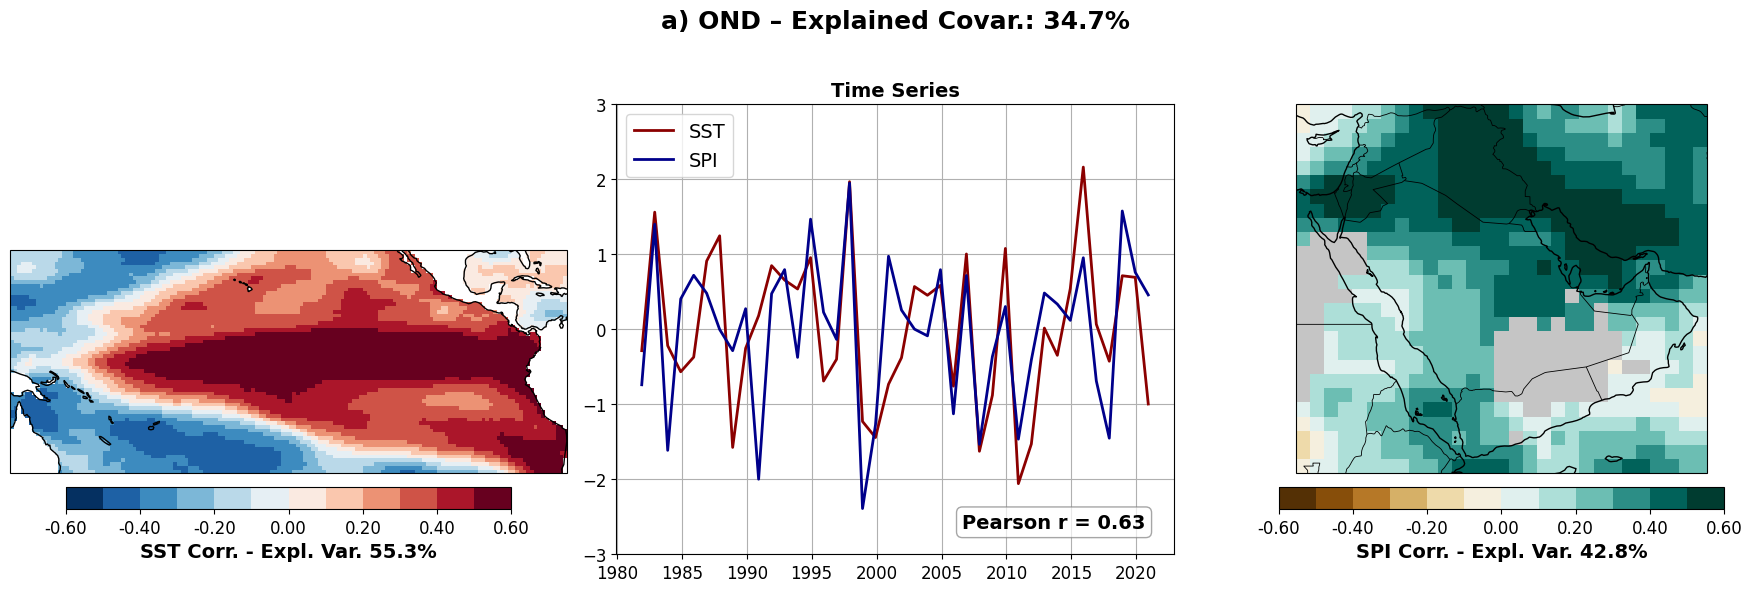

Processing season: OND with detrending


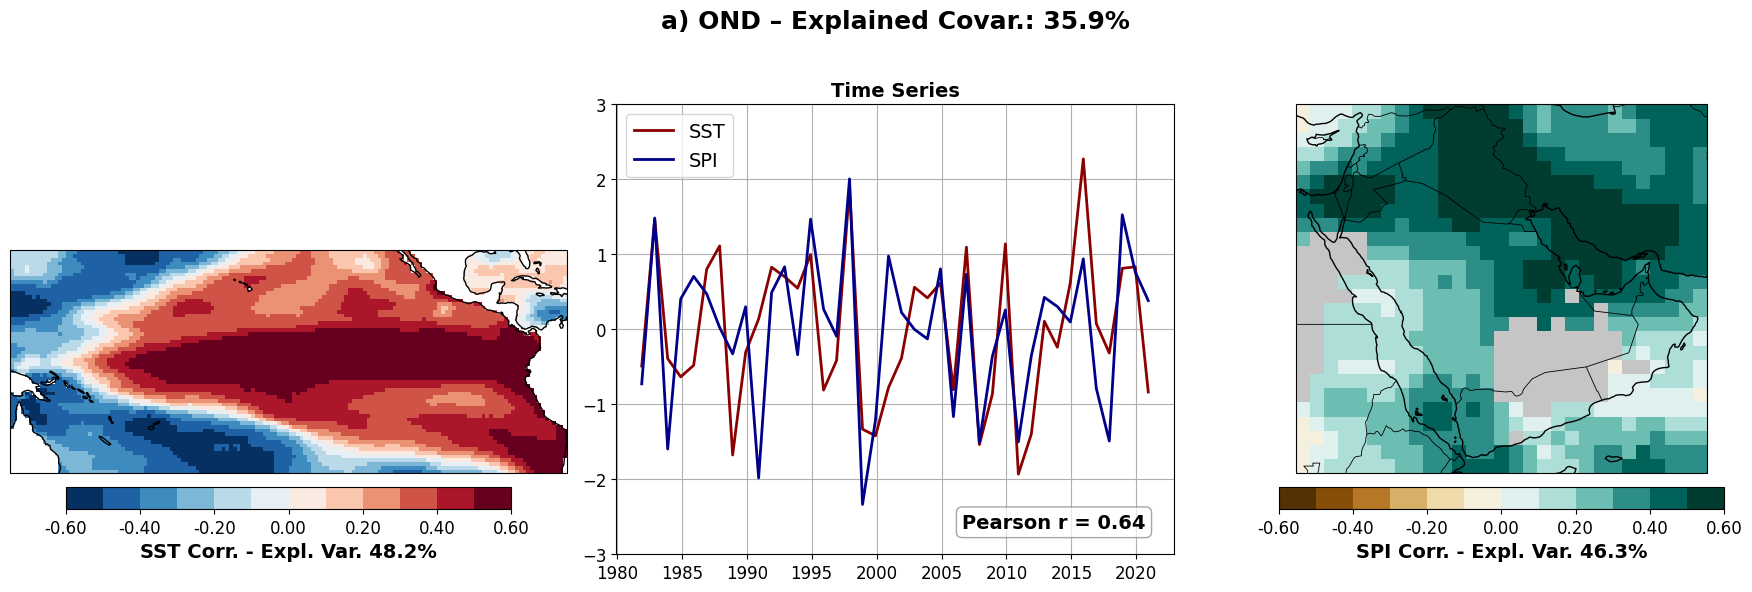

Processing season: NDJ 


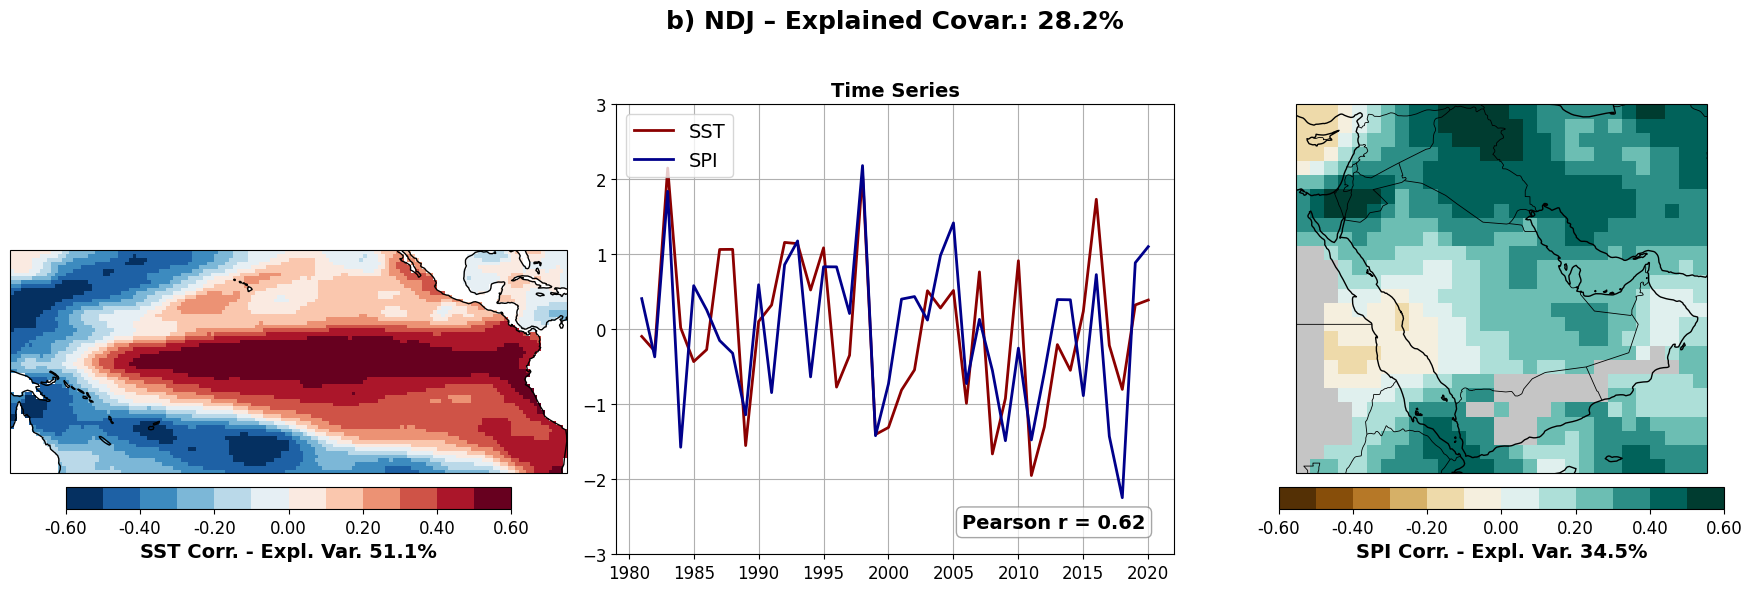

Processing season: NDJ with detrending


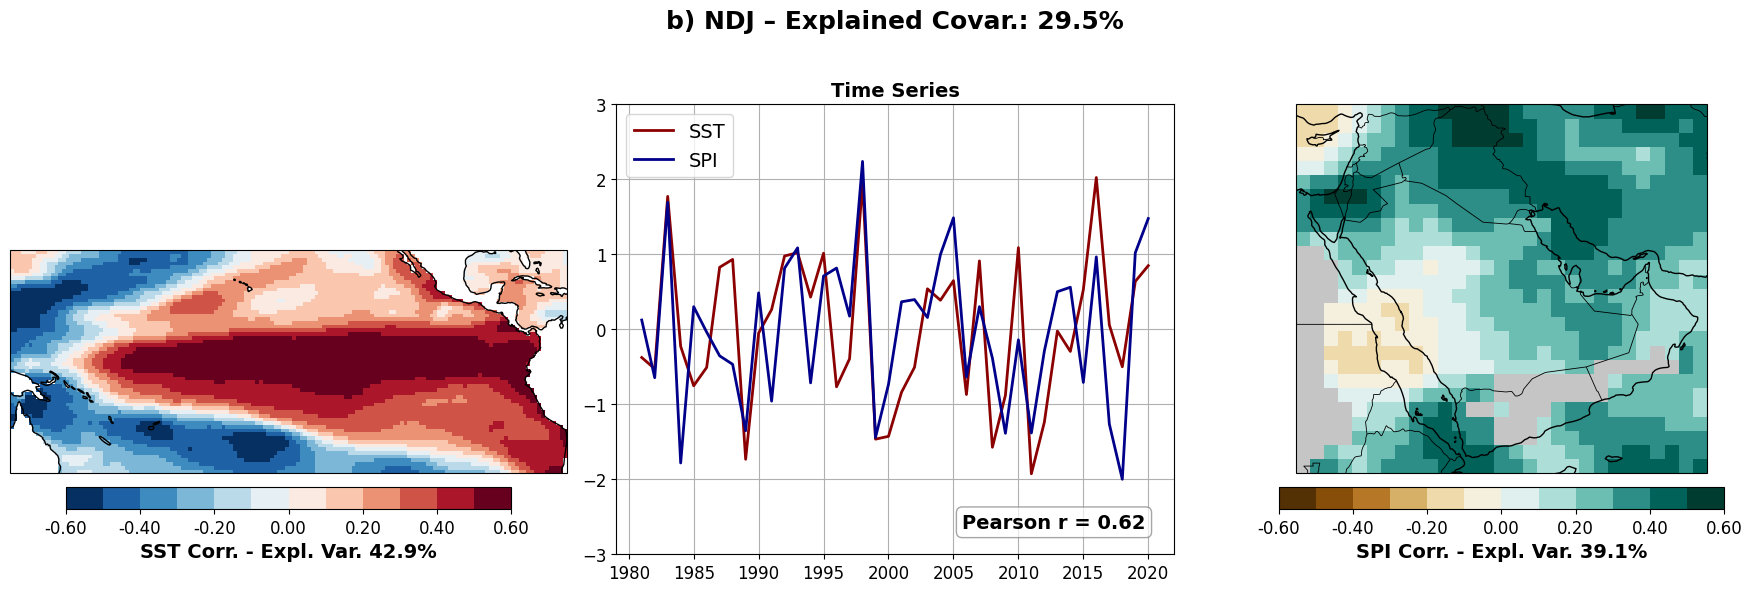

Processing season: DJF 


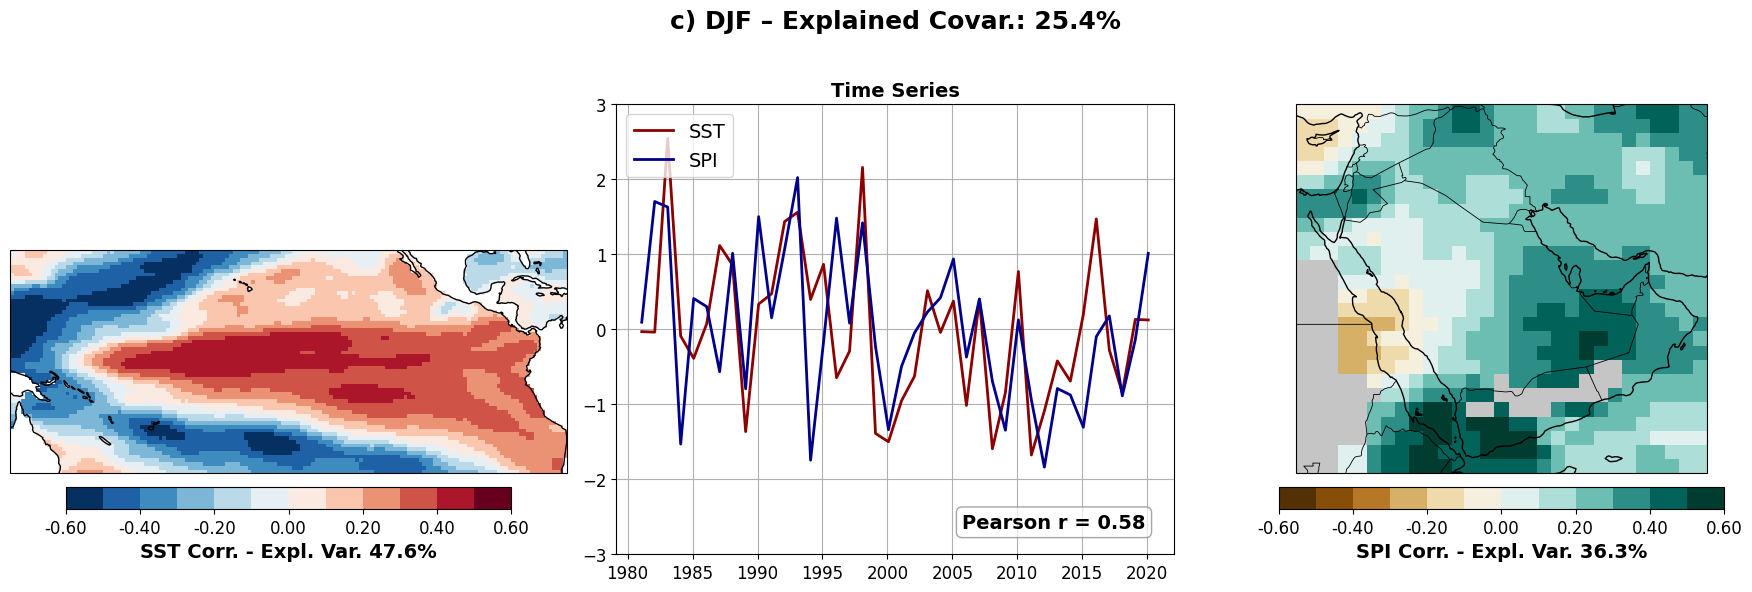

Processing season: DJF with detrending


Processing season: JFM 


Processing season: JFM with detrending


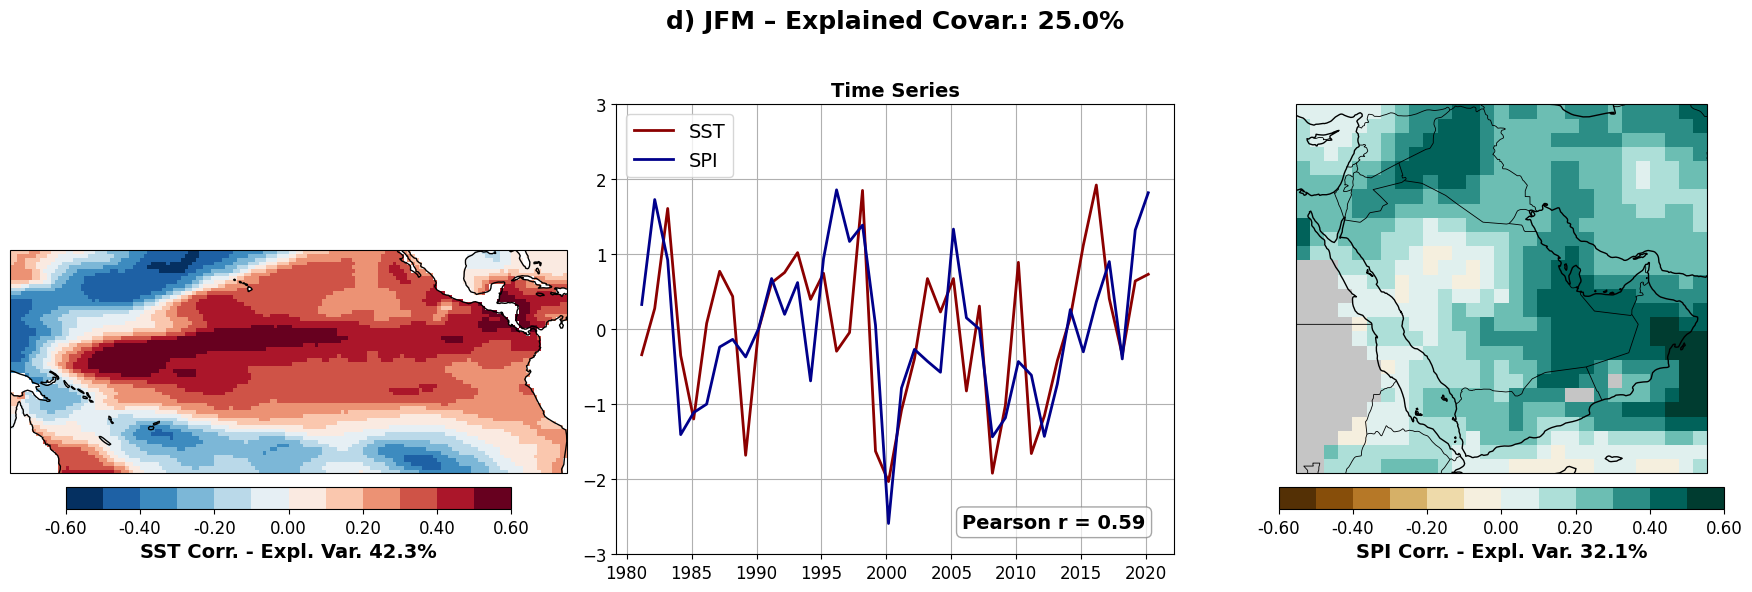

Processing season: FMA 


Processing season: FMA with detrending


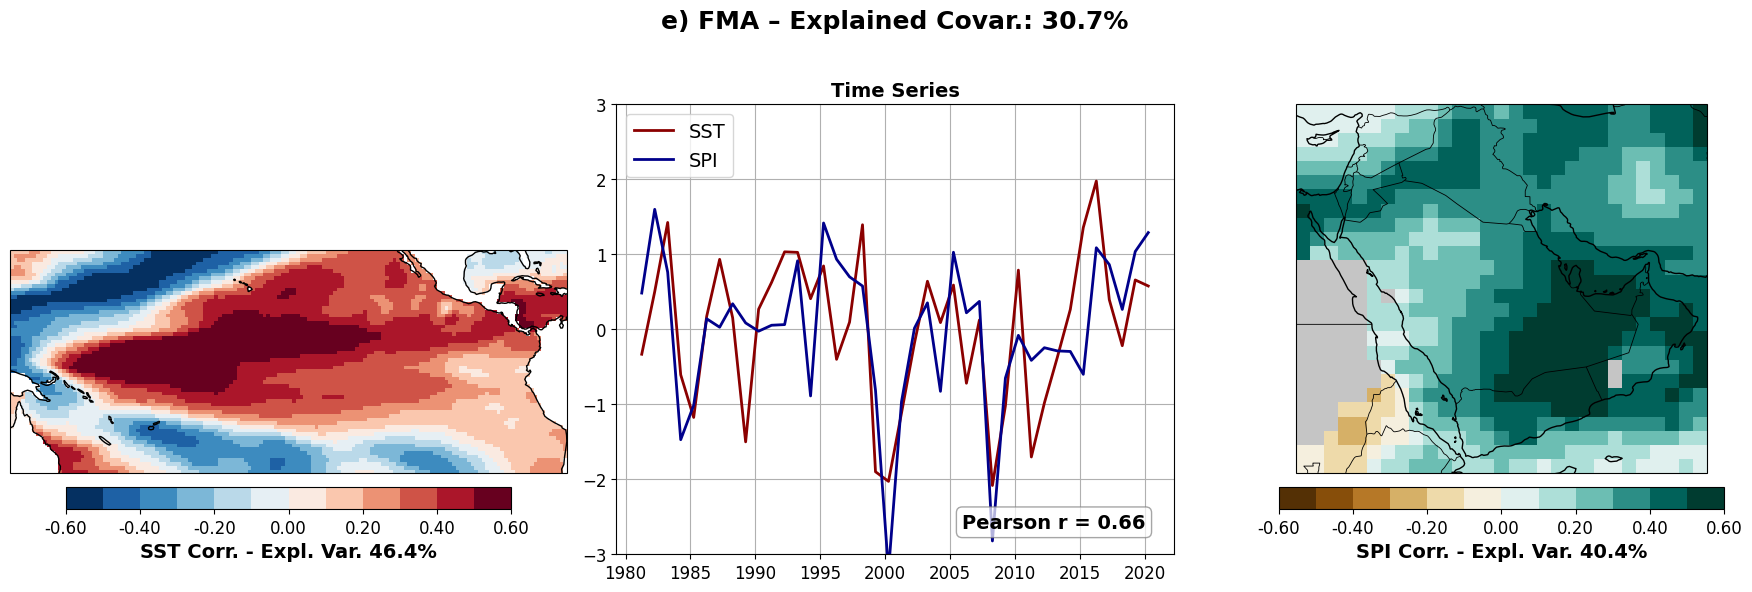

Processing season: MAM 


Processing season: MAM with detrending


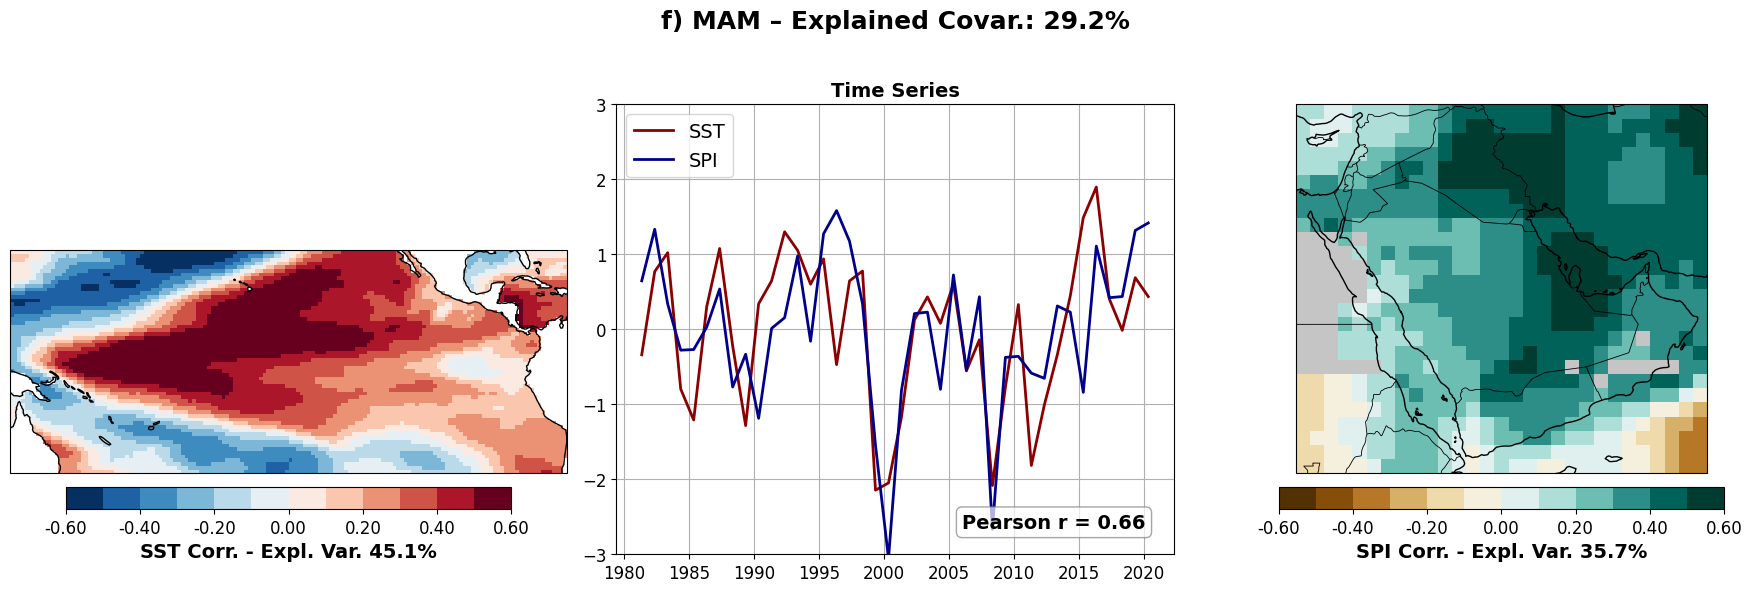

In [17]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    print(f"Processing season: {season} ")
    svd_analysis(sst.sst3m, spi, left_var='SST',n_modes=3, month=season, label=label)
    print(f"Processing season: {season} with detrending")
    svd_analysis(sst.sst3m,spi, left_var='SST', n_modes=3, month=season, label=label,detrend=True)

In [18]:
# def cca_eof_plot(spi, sst, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1,var_name='SST', month=None, label=None,proj=ccrs.Robinson()):


#     if month is not None:
#         months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
#         num_month = months.index(month) + 1
#         spi = spi.sel(time=spi.time.dt.month == num_month)
#         sst = sst.sel(time=sst.time.dt.month == num_month)

#     sst = (sst - sst.mean(dim='time', skipna=True)) / (sst.std(dim='time', skipna=True) + 1e-10)
#     spi = (spi - spi.mean(dim='time', skipna=True)) / (spi.std(dim='time', skipna=True) + 1e-10)

#     # Flatten spatial dims
#     sst_2d = sst.stack(space=('lat', 'lon'))
#     spi_2d = spi.stack(space=('lat', 'lon'))

#     # Remove gridpoints that are fully masked
#     valid_sst = ~sst_2d.isnull().all('time')
#     valid_spi = ~spi_2d.isnull().all('time')

#     sst_valid = sst_2d[:, valid_sst].fillna(0)
#     spi_valid = spi_2d[:, valid_spi].fillna(0)

#     # PCA
#     pca_sst = PCA(n_components=n_pcs_sst, random_state=4)
#     pca_spi = PCA(n_components=n_pcs_spi, random_state=4)
#     sst_pcs = pca_sst.fit_transform(sst_valid)
#     spi_pcs = pca_spi.fit_transform(spi_valid)

#     # CCA
#     cca = CCA(n_components=n_components_cca)
#     sst_c, spi_c = cca.fit_transform(sst_pcs, spi_pcs)


#     def corrcoef_grid(data_valid, canonical_ts):
#     # data_valid: shape (time, space)
#     # canonical_ts: shape (time,)
#         corrs = np.empty(data_valid.shape[1])
#         for i in range(data_valid.shape[1]):
#             corrs[i] = np.corrcoef(data_valid[:, i], canonical_ts)[0, 1]
#         return corrs

#     sst_cmap = corrcoef_grid(sst_valid.values, sst_c[:, 0])
#     spi_cmap = corrcoef_grid(spi_valid.values, spi_c[:, 0])

#     # Fill maps
#     sst_map = xr.full_like(sst_2d.isel(time=0), np.nan)
#     spi_map = xr.full_like(spi_2d.isel(time=0), np.nan)
#     sst_map.values[valid_sst.values] = sst_cmap
#     spi_map.values[valid_spi.values] = spi_cmap
#     sst_map = sst_map.unstack('space')
#     spi_map = spi_map.unstack('space')

#     #if month is DJF or JFM, flip signs of maps
#     if var_name=="SST" and month in ['OND','NDJ','JFM']:
#         sst_map = -sst_map
#         spi_map = -spi_map

#     if var_name == "SLP" and month in ['DJF',"JFM","MAM"]:
#         sst_map = -sst_map
#         spi_map = -spi_map

#     # Compute Pearson correlation between canonical time series
#     r = np.corrcoef(sst_c[:, 0], spi_c[:, 0])[0, 1]

#     # Plot
#     fig = plt.figure(figsize=(18, 6))

#     # SST Canonical map
#     ax1 = fig.add_subplot(1, 3, 1, projection=proj)
#     pcm1 = ax1.pcolormesh(
#         sst_map['lon'], sst_map['lat'], sst_map,
#         transform=ccrs.PlateCarree(), cmap='RdBu_r',
#         vmin=-1, vmax=1
#     )
#     ax1.coastlines()
#     cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar1.set_label(f"{var_name} Canonical Correlations", fontsize=14, fontweight='bold')
#     cbar1.ax.tick_params(labelsize=12)
#     ax1.tick_params(labelsize=12)

#     # Time series
#     ax2 = fig.add_subplot(1, 3, 2)
#     ax2.plot(sst.time, sst_c, label=var_name, color='darkred', linewidth=2)
#     ax2.plot(spi.time, spi_c, label='SPI', color='darkblue', linewidth=2)
#     ax2.set_title("Canonical Time Series", fontsize=14, fontweight='bold')
#     ax2.legend(fontsize=14, loc='upper left')
#     ax2.tick_params(labelsize=12)
#     ax2.grid(True)
#     ax2.set_ylim(-3,3)

#     # Add Pearson r text inside plot (top right corner)
#     ax2.text(0.95, 0.05, f"Pearson r = {r:.2f}",
#              transform=ax2.transAxes,
#              horizontalalignment='right',
#              verticalalignment='bottom',
#              fontsize=14,
#              fontweight='bold',
#              bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

#     # SPI Canonical map

#     ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
#     rdblu = cm.get_cmap('BrBG').copy()
#     rdblu.set_bad(color="#DCD7D7BE")

#     pcm2 = ax3.pcolormesh(
#         spi_map['lon'], spi_map['lat'], spi_map,
#         transform=ccrs.PlateCarree(), cmap=rdblu,
#         vmin=-1, vmax=1
#     )
#     ax3.coastlines()
#     ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
#     cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar2.set_label("SPI Canonical Correlations", fontsize=14, fontweight='bold')
#     cbar2.ax.tick_params(labelsize=12)
#     ax3.tick_params(labelsize=12)

#     plt.suptitle(f"{label} {month}", fontsize=18, fontweight='bold')
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(f'figures/telecos/cca_{var_name}_{month}.pdf', dpi=150)
#     plt.show()


In [19]:
# seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
# labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
# for season, label in zip(seasons, labels):
#     cca_eof_plot(spi, sst.sst3m, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month=season, label=label)


In [20]:
# def cca_eof_plot(spi, sst, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month=None, label=None,var_name="SST"):


#     if month is not None:
#         months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
#         num_month = months.index(month) + 1
#         spi = spi.sel(time=spi.time.dt.month == num_month)
#         sst = sst.sel(time=sst.time.dt.month == num_month)
    
#     sst = (sst - sst.mean(dim='time', skipna=True)) / (sst.std(dim='time', skipna=True) + 1e-10)
#     spi = (spi - spi.mean(dim='time', skipna=True)) / (spi.std(dim='time', skipna=True) + 1e-10)

#     # Flatten spatial dims
#     sst_2d = sst.stack(space=('lat', 'lon'))
#     spi_2d = spi.stack(space=('lat', 'lon'))

#     # Remove gridpoints that are fully masked
#     valid_sst = ~sst_2d.isnull().all('time')
#     valid_spi = ~spi_2d.isnull().all('time')

#     sst_valid = sst_2d[:, valid_sst].fillna(0)
#     spi_valid = spi_2d[:, valid_spi].fillna(0)

#     # PCA
#     pca_sst = PCA(n_components=n_pcs_sst)
#     pca_spi = PCA(n_components=n_pcs_spi)
#     sst_pcs = pca_sst.fit_transform(sst_valid)
#     spi_pcs = pca_spi.fit_transform(spi_valid)

#     # CCA
#     cca = CCA(n_components=n_components_cca)
#     sst_c, spi_c = cca.fit_transform(sst_pcs, spi_pcs)

#     # Compute loadings: project cca weights back to original space
#     sst_load = np.dot(pca_sst.components_.T, cca.x_weights_)[:, 0]
#     spi_load = np.dot(pca_spi.components_.T, cca.y_weights_)[:, 0]

#     # Fill maps with loadings
#     sst_map = xr.full_like(sst_2d.isel(time=0), np.nan)
#     spi_map = xr.full_like(spi_2d.isel(time=0), np.nan)
#     sst_map.values[valid_sst.values] = sst_load
#     spi_map.values[valid_spi.values] = spi_load
#     sst_map = sst_map.unstack('space')
#     spi_map = spi_map.unstack('space')

#     # Compute Pearson correlation between canonical time series themselves
#     r = np.corrcoef(sst_c[:, 0], spi_c[:, 0])[0, 1]

#     # Plot
#     fig = plt.figure(figsize=(18, 6))

#     # SST Canonical loading map
#     ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson())
#     pcm1 = ax1.pcolormesh(
#         sst_map['lon'], sst_map['lat'], sst_map,
#         transform=ccrs.PlateCarree(), cmap='RdBu_r',
#         vmin=-np.nanmax(np.abs(sst_map)), vmax=np.nanmax(np.abs(sst_map))
#     )
#     ax1.coastlines()
#     cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar1.set_label(f"{var_name} Loadings", fontsize=14, fontweight='bold')
#     cbar1.ax.tick_params(labelsize=12)
#     ax1.tick_params(labelsize=12)

#     # Time series
#     ax2 = fig.add_subplot(1, 3, 2)
#     ax2.plot(sst.time, sst_c, label=var_name, color='darkred', linewidth=2)
#     ax2.plot(spi.time, spi_c, label='SPI', color='darkblue', linewidth=2)
#     ax2.set_title("Canonical Time Series", fontsize=14, fontweight='bold')
#     ax2.legend(fontsize=12)
#     ax2.tick_params(labelsize=12)
#     ax2.grid(True)

#     # Pearson r text inside plot (top right corner)
#     ax2.text(0.95, 0.05, f"Pearson r = {r:.2f}",
#              transform=ax2.transAxes,
#              horizontalalignment='right',
#              verticalalignment='bottom',
#              fontsize=14,
#              fontweight='bold',
#              bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

#     # SPI Canonical loading map
#     ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
#     pcm2 = ax3.pcolormesh(
#         spi_map['lon'], spi_map['lat'], spi_map,
#         transform=ccrs.PlateCarree(), cmap='RdBu_r',
#         vmin=-np.nanmax(np.abs(spi_map)), vmax=np.nanmax(np.abs(spi_map))
#     )
#     ax3.coastlines()
#     ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
#     cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar2.set_label("SPI Loadings", fontsize=14, fontweight='bold')
#     cbar2.ax.tick_params(labelsize=12)
#     ax3.tick_params(labelsize=12)

#     plt.suptitle(f"{label} - {month} - CCA1", fontsize=18, fontweight='bold')
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()


In [21]:
# cca_eof_plot(spi,sst.sst3m, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month='OND', label="a)")

# Fig 4 Teleco SLP

In [22]:

#NOAA COBE SST data
slp = xr.open_dataset('data/mslp.mon.mean.nc').sortby('time')


slp['slp3m'] = slp['mslp'] + slp['mslp'].shift(time=1) + slp['mslp'].shift(time=2)

#put lon is -180 to 180
slp = slp.assign_coords(lon=(((slp.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
slp = slp.sel(time=slice(spi['time'][0], spi['time'][-1]))

slp = slp.sel(lat=slice(80, 20), lon=slice(-90, 40))

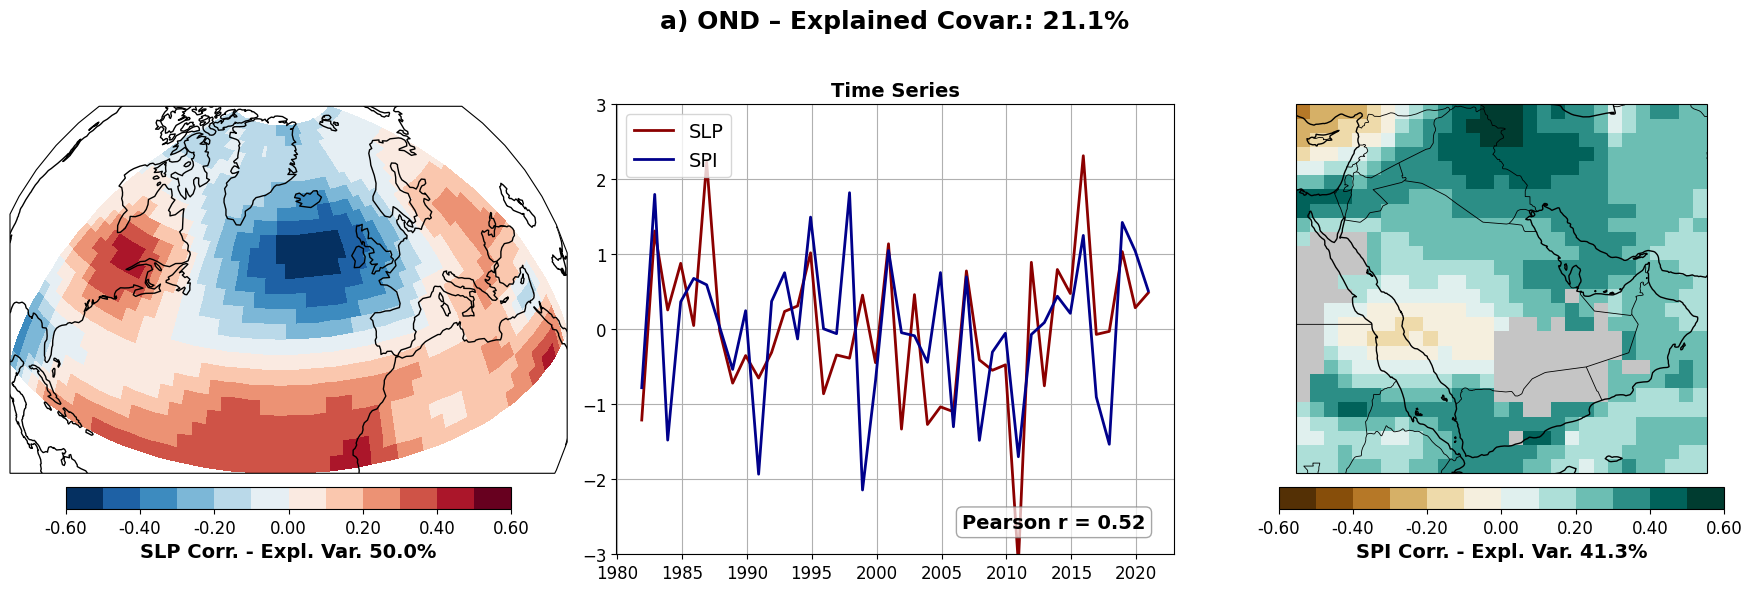

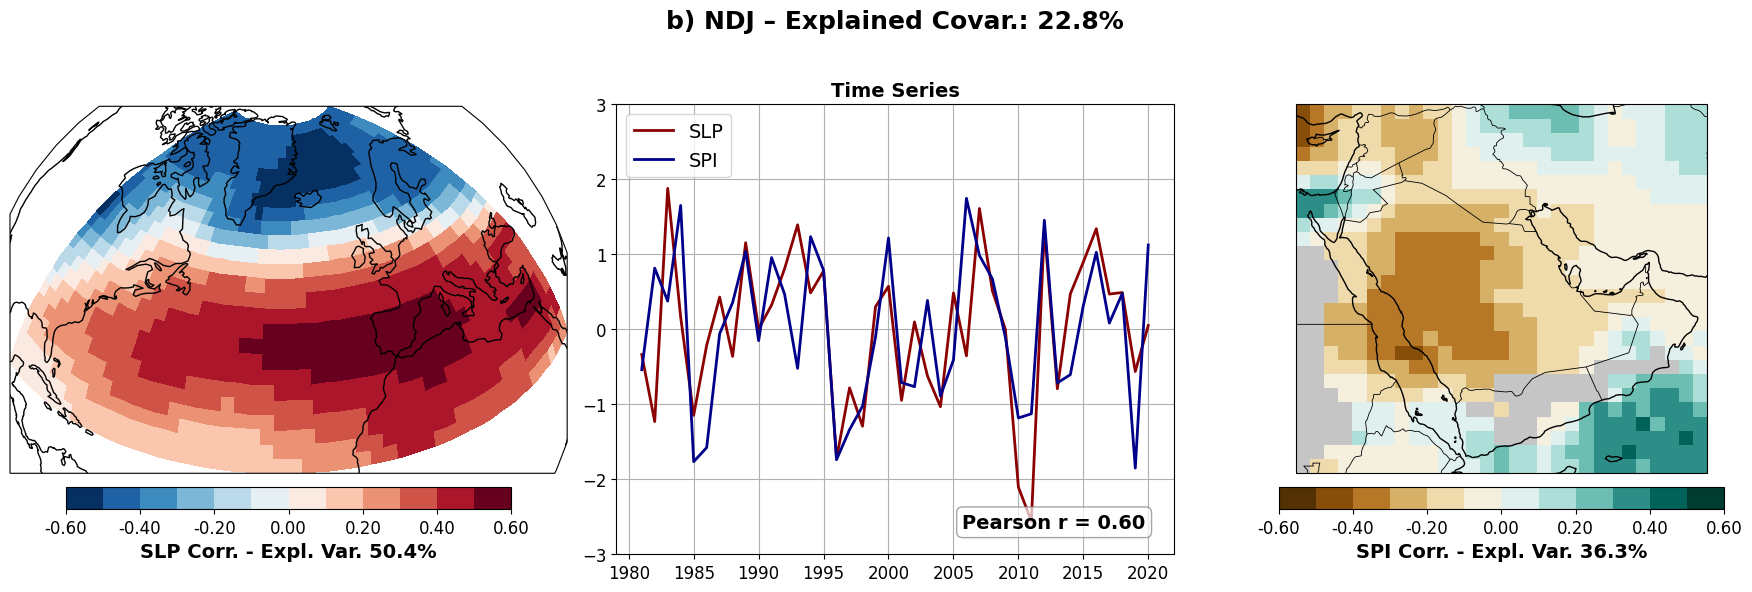

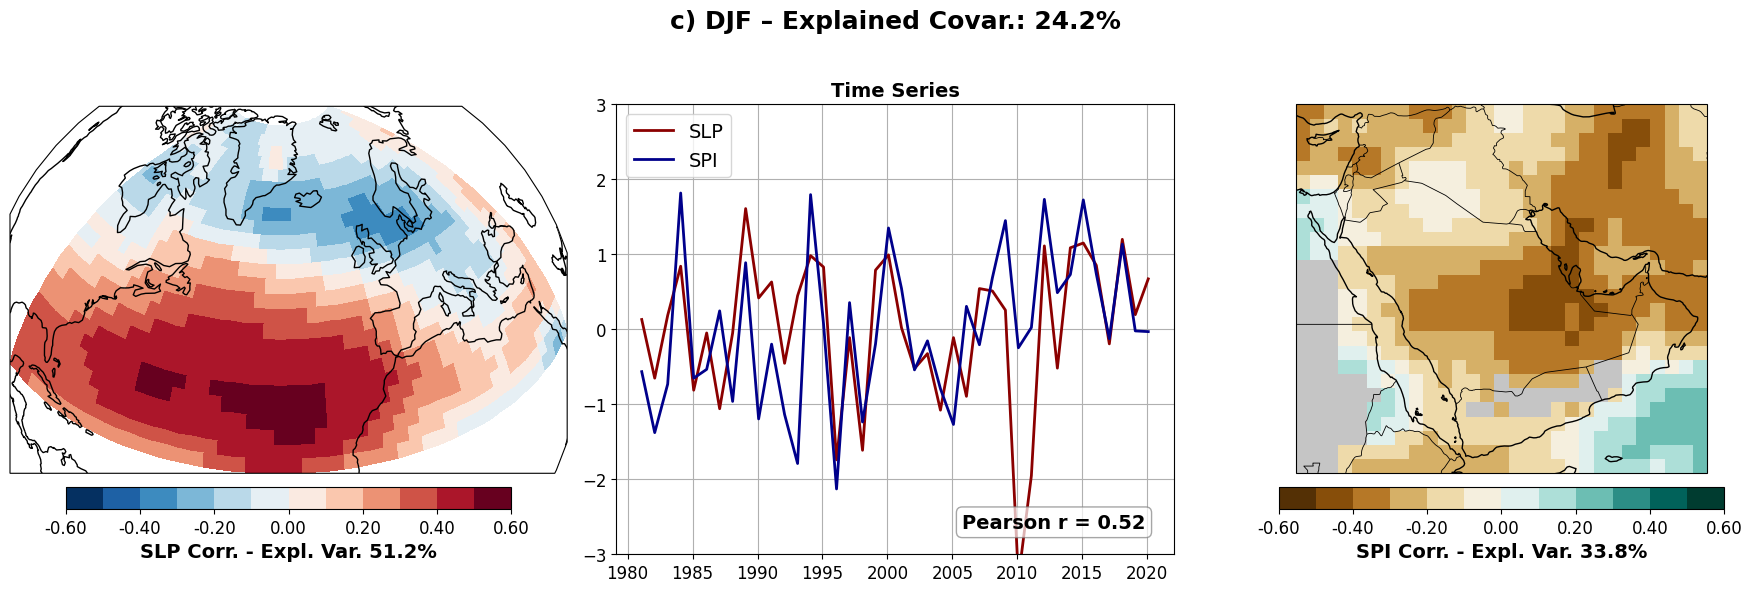

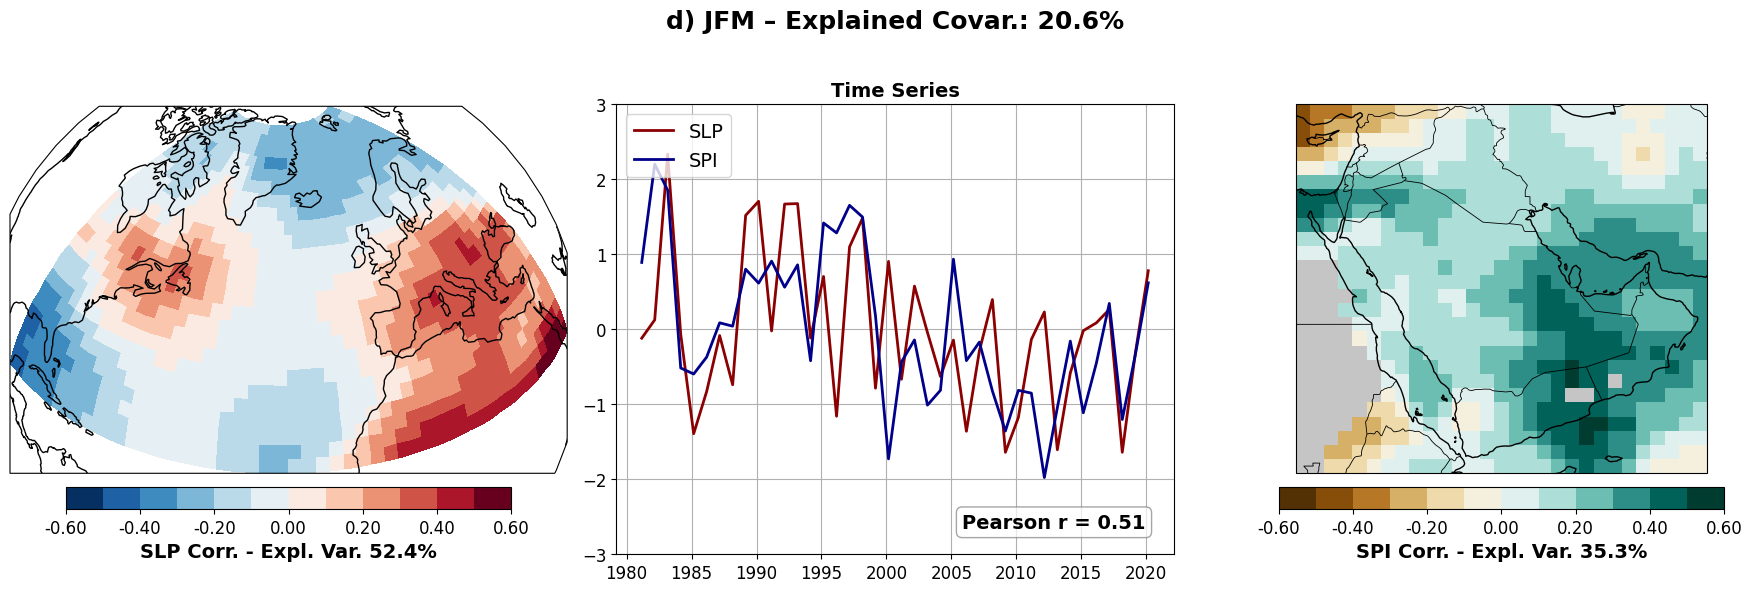

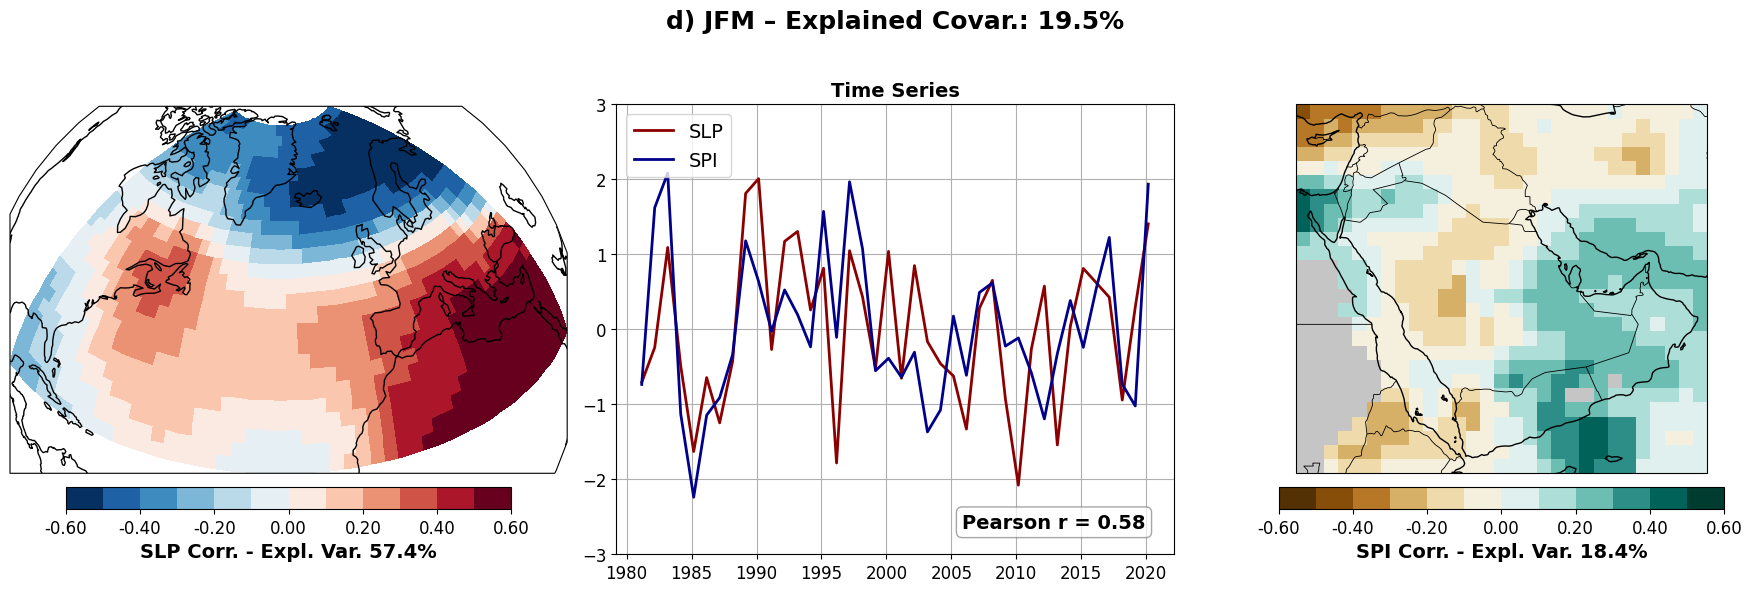

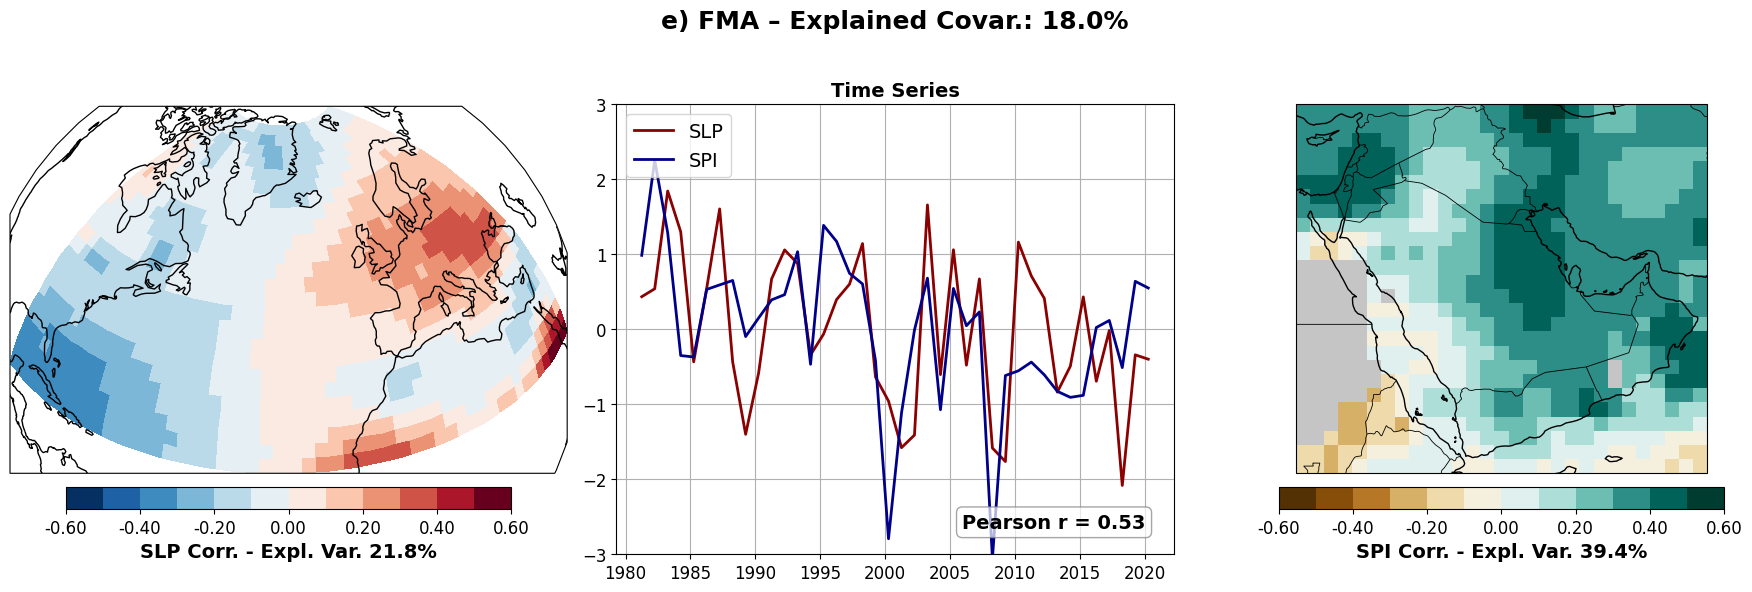

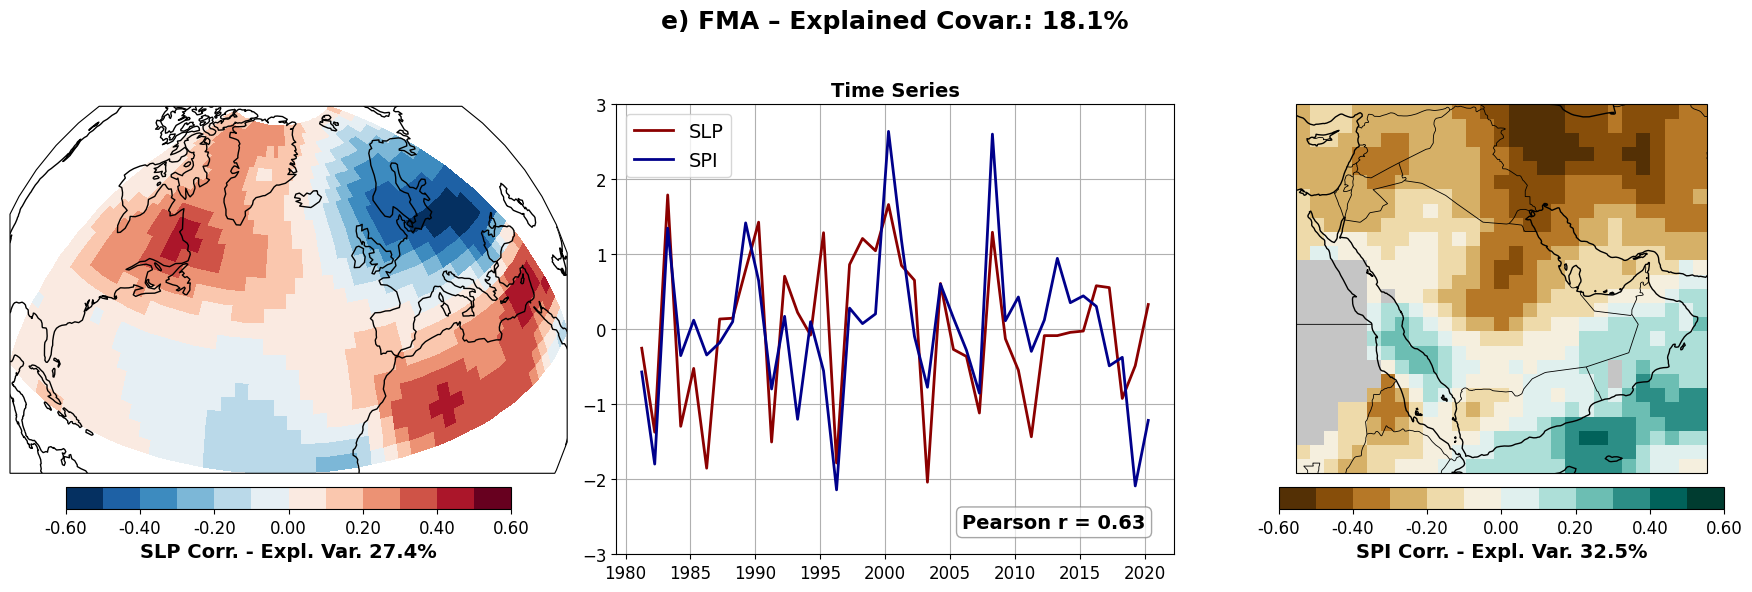

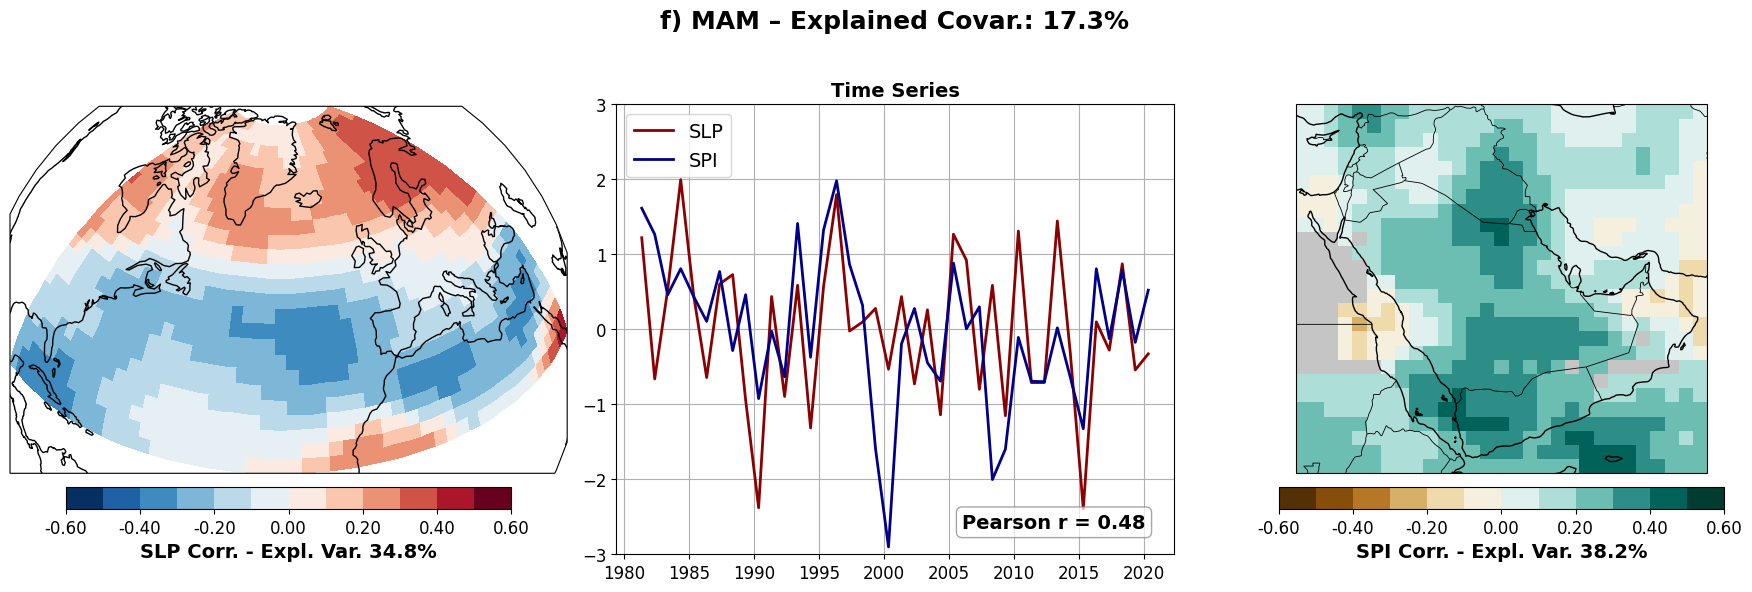

In [23]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    svd_analysis(slp.slp3m,spi,  n_modes=3,
                 month=season, label=label, left_var='SLP',
                 left_proj=ccrs.NearsidePerspective(central_longitude=-30, central_latitude=40))
    svd_analysis(slp.slp3m, spi, n_modes=3,
                 month=season, label=label, left_var='SLP',
                  left_proj=ccrs.NearsidePerspective(central_longitude=-30, central_latitude=40), detrend=True)

# Fig 5  Teleco SLP SSt

In [24]:
# seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
# labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
# for season, label in zip(seasons, labels):
#     svd_analysis(sst.sst3m, slp.slp3m, n_modes=1,
#                  month=season, label=label, left_var='SST', right_var='SLP',
#                  left_proj=ccrs.Robinson(),
#                  right_proj=ccrs.NearsidePerspective(central_longitude=-30, central_latitude=40))

# Empirical Hindcast

In [ ]:
# def svd_regression_correlation_maps(spi, sst, slp, n_modes=1, detrend=False, month=None, model=LinearRegression(),
#                                      proj=ccrs.PlateCarree(), threshold=0.37, region_mask = None):

#     if month is not None:
#         months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ',
#                   'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
#         month_num = months.index(month) + 1
#         sst = sst.sel(time=sst['time.month'] == month_num)
#         slp = slp.sel(time=slp['time.month'] == month_num)
#         spi = spi.sel(time=spi['time.month'] == month_num)

#     spi_mask = spi.isel(time=0).notnull().values

#     def get_pc1(X, Y):
#         if detrend:
#             def xr_detrend(da):
#                 return xr.apply_ufunc(
#                     scipy_detrend, da, input_core_dims=[['time']],
#                     output_core_dims=[['time']], vectorize=True,
#                     dask='parallelized', output_dtypes=[da.dtype])
#             X = xr_detrend(X.fillna(0)).transpose('time', 'lat', 'lon')
#             Y = xr_detrend(Y.fillna(0)).transpose('time', 'lat', 'lon')

#         X = (X - X.mean('time')) / (X.std('time') + 1e-6)
#         Y = (Y - Y.mean('time')) / (Y.std('time') + 1e-6)

#         mca = xMCA(X.fillna(0), Y.fillna(0))
#         mca.apply_coslat()
#         mca.solve()

#         return mca.pcs()['left'].sel(mode=n_modes)

#     # Align time
#     spi = spi.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')
#     sst = sst.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')
#     slp = slp.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')

#     pc1_sst = get_pc1(sst, spi)
#     pc1_slp = get_pc1(slp, spi)

#     lat = spi.lat
#     lon = spi.lon
#     cv_score = xr.full_like(spi.isel(time=0), np.nan)  # 2D map

#     kf = KFold(n_splits=3, shuffle=True, random_state=0)

#     def cv_correlation(y, pc1_sst, pc1_slp, model, kf):
#         if np.isnan(y).all() or np.sum(~np.isnan(y)) < 10:
#             return np.nan

#         mask = ~np.isnan(y)
#         y_clean = y[mask]
#         X = np.stack([pc1_sst[mask], pc1_slp[mask]], axis=-1)

#         corrs = []
#         for train_idx, test_idx in kf.split(X):
#             model.fit(X[train_idx], y_clean[train_idx])
#             y_pred = model.predict(X[test_idx])
#             r, _ = pearsonr(y_clean[test_idx], y_pred)
#             corrs.append(r)
#         return np.mean(corrs) if corrs else np.nan

#     def wrapped_cv(y):
#         return cv_correlation(y, pc1_sst.values, pc1_slp.values, model, kf)



#     cv_score = xr.apply_ufunc(
#         wrapped_cv,
#         spi,
#         input_core_dims=[["time"]],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[float],
#     )

#     # for i in range(len(lat)):
#     #     for j in range(len(lon)):
#     #         y = spi[:, i, j].values
#     #         if np.isnan(y).all():
#     #             continue
#     #         mask = ~np.isnan(y)
#     #         if mask.sum() < 10:
#     #             continue

#     #         y_clean = y[mask]
#     #         X = np.vstack([pc1_sst.values, pc1_slp.values]).T[mask]

#     #         corrs = []
#     #         for train_idx, test_idx in kf.split(X):
#     #             X_train, X_test = X[train_idx], X[test_idx]
#     #             y_train, y_test = y_clean[train_idx], y_clean[test_idx]

#     #             model.fit(X_train, y_train)
#     #             y_pred = model.predict(X_test)


#     #             r, _ = pearsonr(y_test, y_pred)
#     #             corrs.append(r)

#     #         if corrs:
#     #             cv_score[i, j] = np.mean(corrs)

#     # Save to a DataArray for plotting
#     r_map = xr.DataArray(cv_score, coords=[lat, lon], dims=['lat', 'lon'])
#     r_map = r_map.where(spi_mask)
#     if region_mask is not None:
#         r_map = r_map.where(region_mask==0, np.nan)
        

#     # === Plotting ===
#     levels = np.arange(-1, 1.1, 0.1)
#     fig, ax = plt.subplots(1, 1, figsize=(8, 5), subplot_kw={'projection': proj})

#     #custom colormap with gray for NaNs
#     rdblu = cm.get_cmap('RdBu_r').copy()
#     rdblu.set_bad(color='white', alpha=0.45)

#     r_map.plot(
#         vmin=-1, vmax=1, cmap=rdblu, ax=ax, cbar_kwargs={
#             'orientation': 'vertical', 'pad': 0.03, 'shrink': 0.8, 'label': '',},
#         add_colorbar=True, levels=levels, transform=ccrs.PlateCarree()
#     )
#     ax.coastlines()
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#     #ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='white', alpha=0.5)
#     ax.set_title(f" {month}", fontsize=14, fontweight='bold')

#     # Mask and scatter for significant correlation
#     mask = r_map > threshold
#     x_vals = r_map.coords['lon'].values
#     y_vals = r_map.coords['lat'].values
#     lon2d, lat2d = np.meshgrid(x_vals, y_vals)

#     ax.scatter(
#         lon2d[mask], lat2d[mask],
#         color='black', s=10, transform=ccrs.PlateCarree(),
#         label=f'Corr > {threshold}'
#     )
#     ax.legend(loc='lower right', fontsize=9)

#     plt.tight_layout()
#     plt.savefig(f'figures/hindcast/STAT_{month}_corr.pdf', dpi=150)
#     plt.show()
#     return r_map


In [ ]:
def svd_regression_correlation_maps(
    spi, sst, slp, n_modes=1, detrend=False, month=None,
    model=None, param_grid=None, proj=ccrs.PlateCarree(),
    threshold=0.37, region_mask=None
):
    # === Filter by month if needed ===
    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ',
                  'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        sst = sst.sel(time=sst['time.month'] == month_num)
        slp = slp.sel(time=slp['time.month'] == month_num)
        spi = spi.sel(time=spi['time.month'] == month_num)

    # Mask for NaNs in the first timestep
    spi_mask = spi.isel(time=0).notnull().values

    # === Helper: detrending ===
    def xr_detrend(da):
        return xr.apply_ufunc(
            scipy_detrend, da, input_core_dims=[['time']],
            output_core_dims=[['time']], vectorize=True,
            dask='parallelized', output_dtypes=[da.dtype]
        )

    # === Helper: extract PC1 ===
    def get_pc1(X, Y):
        if detrend:
            X = xr_detrend(X.fillna(0)).transpose('time', 'lat', 'lon')
            Y = xr_detrend(Y.fillna(0)).transpose('time', 'lat', 'lon')
        X = (X - X.mean('time')) / (X.std('time') + 1e-6)
        Y = (Y - Y.mean('time')) / (Y.std('time') + 1e-6)

        mca = xMCA(X.fillna(0), Y.fillna(0))
        mca.apply_coslat()
        mca.solve()
        return mca.pcs()['left'].sel(mode=n_modes)

    # Align period
    period = slice('1991-01-01', '2020-12-31')
    spi = spi.sel(time=period).transpose('time', 'lat', 'lon')
    sst = sst.sel(time=period).transpose('time', 'lat', 'lon')
    slp = slp.sel(time=period).transpose('time', 'lat', 'lon')

    # Extract PC1 series
    pc1_sst = get_pc1(sst, spi).values
    pc1_slp = get_pc1(slp, spi).values

    # === Custom CV correlation function ===
    def cv_correlation(y):
        if np.isnan(y).all() or np.sum(~np.isnan(y)) < 10:
            return np.nan

        mask = ~np.isnan(y)
        y_clean = y[mask]
        X = np.stack([pc1_sst[mask], pc1_slp[mask]], axis=-1)

        kf = KFold(n_splits=3, shuffle=True, random_state=0)

        if param_grid is not None:
            scorer = make_scorer(lambda yt, yp: pearsonr(yt, yp)[0],
                                 greater_is_better=True)
            grid = GridSearchCV(model, param_grid, cv=kf, scoring=scorer)
            grid.fit(X, y_clean)
            return grid.best_score_
        else:
            corrs = []
            for train_idx, test_idx in kf.split(X):
                m = clone(model)
                m.fit(X[train_idx], y_clean[train_idx])
                y_pred = m.predict(X[test_idx])
                r, _ = pearsonr(y_clean[test_idx], y_pred)
                corrs.append(r)
            return np.mean(corrs) if corrs else np.nan

    # Vectorized application
    cv_score = xr.apply_ufunc(
        cv_correlation,
        spi,
        input_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    # Convert to DataArray & mask
    r_map = xr.DataArray(cv_score, coords=[spi.lat, spi.lon], dims=['lat', 'lon'])
    r_map = r_map.where(spi_mask)
    if region_mask is not None:
        r_map = r_map.where(region_mask == 0, np.nan)

    # === Plotting ===
    levels = np.arange(-1, 1.1, 0.1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), subplot_kw={'projection': proj})

    rdblu = cm.get_cmap('RdBu_r').copy()
    rdblu.set_bad(color='white', alpha=0.45)

    r_map.plot(
        vmin=-1, vmax=1, cmap=rdblu, ax=ax,
        cbar_kwargs={'orientation': 'vertical', 'pad': 0.03, 'shrink': 0.8, 'label': ''},
        add_colorbar=True, levels=levels, transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(f"{month}", fontsize=14, fontweight='bold')

    mask = r_map > threshold
    lon2d, lat2d = np.meshgrid(r_map.lon.values, r_map.lat.values)
    ax.scatter(lon2d[mask], lat2d[mask], color='black', s=10,
               transform=ccrs.PlateCarree(), label=f'Corr > {threshold}')
    ax.legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'figures/hindcast/STAT_{month}_corr.pdf', dpi=150)
    plt.show()

    return r_map


## OLS

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


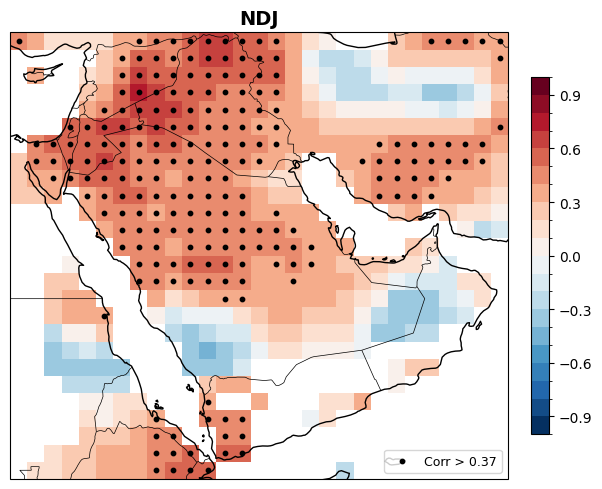

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


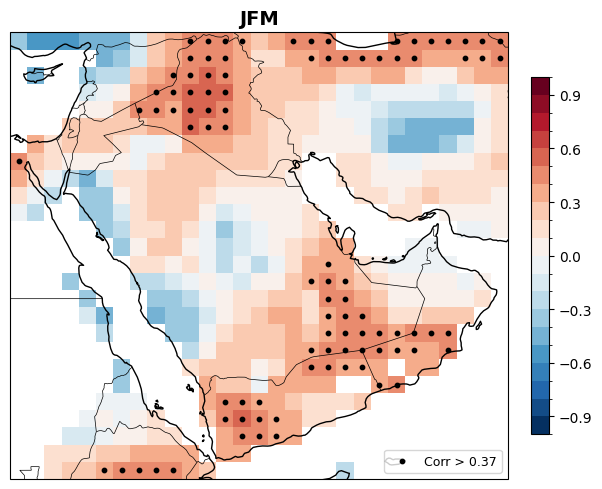

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


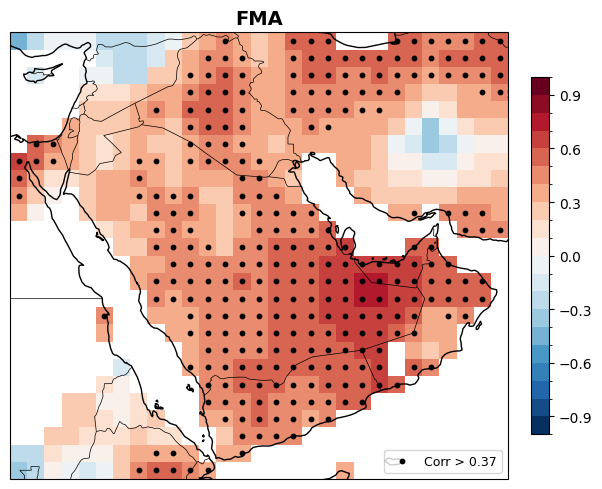

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


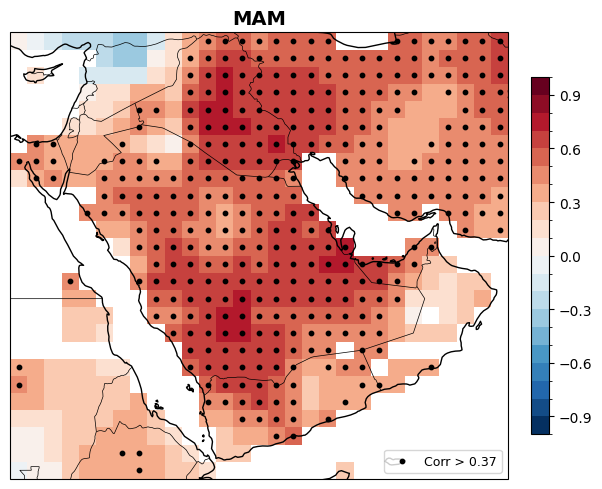

In [ ]:

corrmap_stat = {}
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(lon_or_obj=spi.lon,
    lat = spi.lat
)
for month in ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']:

    r_map = svd_regression_correlation_maps(
        spi=spi,
        sst=sst.sst3m,
        slp=slp.slp3m,
        month=month,
        n_modes=1,
        model = LinearRegression(),
        detrend=True,
        region_mask=mask
    )
    corrmap_stat[month] = r_map

## RF

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\708768547.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdblu = cm.get_cmap('RdBu_r').copy()


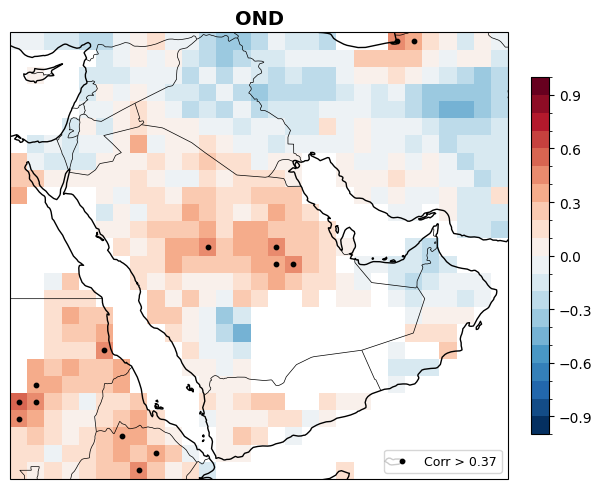

KeyboardInterrupt: 

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import Ridge, Lasso

# param_grid = {
#     "n_estimators": [5,10,20],         # Fewer trees to reduce variance
#     "max_depth": [3, 5],         # Limit depth for small data
# }

# #param_grid = {'alpha': [0.001, 0.01, 0.1, 0.95]}

# corrmap_stat_ML = {}
# mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(lon_or_obj=spi.lon,
#     lat = spi.lat
# )
# for month in ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']:

#     r_map = svd_regression_correlation_maps(
#         spi=spi,
#         sst=sst.sst3m,
#         slp=slp.slp3m,
#         month=month,
#         n_modes=1,
#         model = LinearRegression(),
#         #param_grid=param_grid,
#         detrend=True,
#         region_mask=mask
#     )
#     corrmap_stat_ML[month] = r_map

## With Leads

In [ ]:
# def svd_regression_correlation_maps(spi, sst, slp, n_modes=1, detrend=False, month=None, model=LinearRegression(),
#                                     region_mask = None,
#                                      proj=ccrs.PlateCarree(), threshold=0.37, lead_time=0.5, cv=3):
    
#     def get_center_month(month):
#         months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ',
#                   'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
#         return months.index(month) + 1  # 1-indexed

#     def shift_season(season_month, shift):
#         shift = int(np.floor(shift))
#         return (season_month - shift - 1) % 12 + 1  # ensures 1-12

#     def select_by_month(ds, month):
#         return ds.sel(time=ds['time.month'] == month)

#     def get_pc1(X, Y):
#         if detrend:
#             def xr_detrend(da):
#                 return xr.apply_ufunc(
#                     scipy_detrend, da, input_core_dims=[['time']],
#                     output_core_dims=[['time']], vectorize=True,
#                     dask='parallelized', output_dtypes=[da.dtype])
#             X = xr_detrend(X.fillna(0))
#             Y = xr_detrend(Y.fillna(0))

#         X = X.transpose('time', 'lat', 'lon')
#         Y = Y.transpose('time', 'lat', 'lon')

#         X = (X - X.mean('time')) / (X.std('time') + 1e-6)
#         Y = (Y - Y.mean('time')) / (Y.std('time') + 1e-6)

#         mca = xMCA(X.fillna(0), Y.fillna(0))
#         mca.apply_coslat()
#         mca.solve()

#         return mca.pcs()['left'].sel(mode=n_modes)

#     # === Temporal alignment ===
#     target_month = get_center_month(month)
#     predictor_month = shift_season(target_month, lead_time)


#     spi = spi.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')
#     sst = sst.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')
#     slp = slp.sel(time=slice('1991-01-01', '2020-12-31')).transpose('time', 'lat', 'lon')

#     spi = select_by_month(spi, target_month)
#     sst = select_by_month(sst, predictor_month)
#     slp = select_by_month(slp, predictor_month)


#     # Restrict to common time window
#     #common_time = np.intersect1d(np.intersect1d(spi.time.values, sst.time.values), slp.time.values)
#     #print(f"Common time period: {common_time}")
#     spi = spi.transpose('time', 'lat', 'lon')
#     sst = sst.transpose('time', 'lat', 'lon')
#     slp = slp.transpose('time', 'lat', 'lon')

#     #remove first time step of spi and last time step of sst and slp 
#     if lead_time > 0.5 and target_month < predictor_month:
#         spi = spi.isel(time=slice(1, None))
#         sst = sst.isel(time=slice(None, -1))
#         slp = slp.isel(time=slice(None, -1))


#     print(spi.time.values[0], sst.time.values[0], slp.time.values[0])

#     # === MCA regression ===
#     pc1_sst = get_pc1(sst, spi)
#     pc1_slp = get_pc1(slp, spi)

#     lat = spi.lat
#     lon = spi.lon
#     cv_score = xr.full_like(spi.isel(time=0), np.nan)  # 2D map

#     kf = KFold(n_splits=3, shuffle=True, random_state=0)

#     def cv_correlation(y, pc1_sst, pc1_slp, model, kf):
#         if np.isnan(y).all() or np.sum(~np.isnan(y)) < 10:
#             return np.nan

#         mask = ~np.isnan(y)
#         y_clean = y[mask]
#         X = np.stack([pc1_sst[mask], pc1_slp[mask]], axis=-1)

#         corrs = []
#         for train_idx, test_idx in kf.split(X):
#             model.fit(X[train_idx], y_clean[train_idx])
#             y_pred = model.predict(X[test_idx])
#             r, _ = pearsonr(y_clean[test_idx], y_pred)
#             corrs.append(r)
#         return np.mean(corrs) if corrs else np.nan

#     def wrapped_cv(y):
#         return cv_correlation(y, pc1_sst.values, pc1_slp.values, model, kf)


#     cv_score = xr.apply_ufunc(
#         wrapped_cv,
#         spi,
#         input_core_dims=[["time"]],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[float],
#     )

#     r_map = xr.DataArray(cv_score, coords=[lat, lon], dims=['lat', 'lon'])
#     r_map = r_map.where(spi.isel(time=0).notnull())
#     if regionmask is not None:
#         r_map = r_map.where(region_mask==0, np.nan)

#     # === Plotting ===
#     levels = np.arange(-1, 1.1, 0.1)
#     fig, ax = plt.subplots(1, 1, figsize=(8, 5), subplot_kw={'projection': proj})

#     r_map.plot(
#         vmin=-1, vmax=1, cmap='RdBu_r', levels=levels,
#         cbar_kwargs={'label': 'Correlation (CV)'}, ax=ax,
#         transform=ccrs.PlateCarree()
#     )
#     ax.coastlines()
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#     ax.set_title(f"{month} - Lead: {lead_time} month(s) (CV={cv})", fontsize=14)

#     # Scatter significant correlation points
#     mask = r_map > threshold
#     lon2d, lat2d = np.meshgrid(r_map.lon.values, r_map.lat.values)
#     ax.scatter(
#         lon2d[mask], lat2d[mask],
#         color='black', s=10, transform=ccrs.PlateCarree(),
#         label=f'Corr > {threshold}'
#     )
#     ax.legend(loc='lower right', fontsize=9)
#     plt.tight_layout()
#     plt.show()

#     return r_map

In [ ]:
# corrmap_stat = {}
# mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(lon_or_obj=spi.lon,
#     lat = spi.lat
# )
# for month in ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']:

#     r_map = svd_regression_correlation_maps(
#         spi=spi,
#         sst=sst.sst3m,
#         slp=slp.slp3m,
#         month=month,
#         n_modes=1,
#         lead_time=2.5,
#         model = LinearRegression(),
#         detrend=False,
#         region_mask=mask
#     )
#     corrmap_stat[month] = r_map

# Comparison with Dynamical Hindcast

In [ ]:
# --- Load Data ---

spi_multimodel = xr.open_dataset('data/spi_hindcast_multimodel.nc').spi

#rename dimensions to match the SPI data
spi_multimodel = spi_multimodel.rename({'X': 'lon', 'Y': 'lat', 'S': 'S'})


# --- Create Global Land Mask (based on grid of multimodel as reference) ---
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi_multimodel.lon, spi_multimodel.lat
)


spi_multimodel = spi_multimodel.where(mask == 0, np.nan)



In [ ]:
corrmap_dyn = {}

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 
           'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

# --- Loop over start months and lead times ---
for s_month in range(1, 13):  # Start months
    for lead_int in range(0, 6):  # For lead times 0,1,2,3,4 => 0.5 to 4.5
        lead_time = int(lead_int)  # floor
        lead = lead_time + 0.5     # fractional lead (matching model's lead index)

        # --- Target month ---
        t_month = (s_month + lead_time) % 12
        if t_month == 0:
            t_month = 12

        season_name = seasons[t_month - 1]  # Map target month to season

        # --- Get forecast SPI ---
        spi_fcst_mon = spi_multimodel.sel(S=spi_multimodel['S.month'] == s_month).isel(L=lead_time).drop_vars('L')

        # --- Shift forecast to target time ---
        S_values = spi_fcst_mon['S'].values
        T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
        spi_fcst_mon['S'] = T_values
        spi_fcst_mon = spi_fcst_mon.rename({'S': 'time'}).transpose('time', 'lat', 'lon')
        spi = spi.transpose('time', 'lat', 'lon')
        spi_fcst_mon = spi_fcst_mon.sel(time=slice('1991-01-01', '2020-12-31'))
        spi_obs_mon = spi.sel(time=spi_fcst_mon['time'])

        # --- Compute correlation ---
        corr = xr.corr(spi_fcst_mon, spi_obs_mon, dim='time')

        # --- Store ---
        if season_name not in corrmap_dyn:
            corrmap_dyn[season_name] = {}

        corrmap_dyn[season_name][lead] = corr

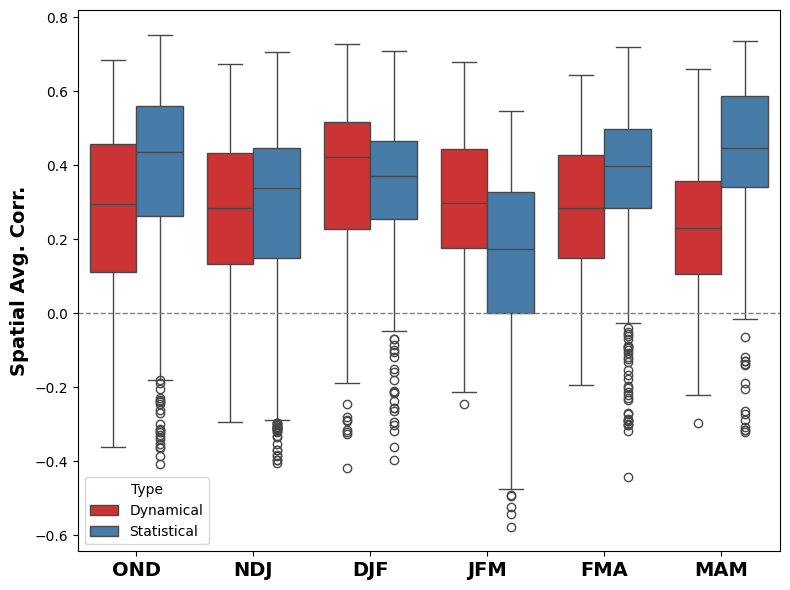

In [ ]:
df_list = []

for season in corrmap_stat.keys():
    lead_time = 2.5
    # Flatten the spatial correlation maps and drop NaNs
    dyn_values = corrmap_dyn[season][lead_time].values.flatten()
    stat_values = corrmap_stat[season].values.flatten()

    dyn_values = dyn_values[~np.isnan(dyn_values)]
    stat_values = stat_values[~np.isnan(stat_values)]

    # Create dataframe for each and label
    df_dyn = pd.DataFrame({
        'Correlation': dyn_values,
        'Season': season,
        'Type': 'Dynamical'
    })

    df_stat = pd.DataFrame({
        'Correlation': stat_values,
        'Season': season,
        'Type': 'Statistical'
    })

    df_list.extend([df_dyn, df_stat])

# Combine all into one dataframe
df_all = pd.concat(df_list, ignore_index=True)

# Sort seasons if needed
season_order = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
df_all['Season'] = pd.Categorical(df_all['Season'], categories=season_order, ordered=True)
df_all = df_all.sort_values('Season')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_all, x='Season', y='Correlation', hue='Type', palette='Set1')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks( fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Spatial Avg. Corr.', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/hindcast/comp_stat_dyn.pdf', dpi=150)
plt.show()

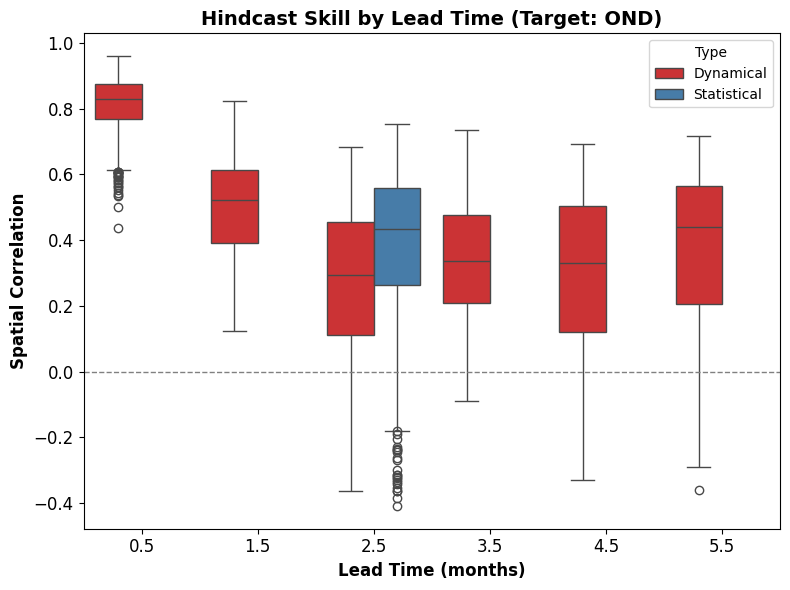

In [ ]:
# --- Setup ---
target_season = 'OND'  # Change as needed
lead_times = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Lead times available for DYN model
stat_lead = 2.5  # Lead time at which STAT is available

df_list = []

# --- DYN entries ---
for lead in lead_times:
    if target_season not in corrmap_dyn or lead not in corrmap_dyn[target_season]:
        continue  # skip if missing

    corr_dyn = corrmap_dyn[target_season][lead]
    values_dyn = corr_dyn.values.flatten()
    values_dyn = values_dyn[~np.isnan(values_dyn)]

    df_dyn = pd.DataFrame({
        'Correlation': values_dyn,
        'Lead Time': lead,
        'Type': 'Dynamical'
    })
    df_list.append(df_dyn)

# --- STAT entry (only at stat_lead) ---
if target_season in corrmap_stat:
    corr_stat = corrmap_stat[target_season]
    values_stat = corr_stat.values.flatten()
    values_stat = values_stat[~np.isnan(values_stat)]

    df_stat = pd.DataFrame({
        'Correlation': values_stat,
        'Lead Time': stat_lead,
        'Type': 'Statistical'
    })
    df_list.append(df_stat)

# --- Combine ---
df_all = pd.concat(df_list, ignore_index=True)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_all, x='Lead Time', y='Correlation', hue='Type', palette='Set1')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Hindcast Skill by Lead Time (Target: {target_season})', fontsize=14, fontweight='bold')
plt.xlabel('Lead Time (months)', fontsize=12, fontweight='bold')
plt.ylabel('Spatial Correlation', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig(f'figures/hindcast/skill_dyn_vs_stat_{target_season}.pdf', dpi=150)
plt.show()

# Indices - NINO NAO DMI

In [ ]:
djd

NameError: name 'djd' is not defined

In [ ]:
nino = pd.read_table('data/nino.txt', delim_whitespace=True)
#create a datetime index from columns YR and MON
nino['T'] = pd.to_datetime(nino['YR'].astype(str) + '-' + nino['MON'].astype(str))
nino['NINO3.4_3m'] = nino['NINO3.4'].rolling(window=3).sum()
#fill na with columns NINO3.4
nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)
nino = nino[nino['T'].dt.year >= 1951]
#add to data xarray with X and Y as coordinates 
nino_xr = xr.Dataset({'NINO': ('T', nino['NINO3.4_3m'].values)}, coords={'T': nino['T']})


C:\Users\emile\AppData\Local\Temp\ipykernel_10608\1005440872.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino = pd.read_table('data/nino.txt', delim_whitespace=True)
C:\Users\emile\AppData\Local\Temp\ipykernel_10608\1005440872.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)


In [ ]:
nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
nao['YR'] = nao[0]
nao['MON'] = nao[1]
nao['nao'] = nao[2]
#create a datetime index from columns YR and MON
nao['T'] = pd.to_datetime(nao['YR'].astype(str) + '-' + nao['MON'].astype(str))
nao['nao_3m'] = nao['nao'].rolling(window=3).sum()
#fill na with columns nao3.4
nao['nao_3m'].fillna(nao['nao'], inplace=True)
nao = nao[nao['T'].dt.year >= 1951]
#stop at 08-2024
nao = nao[nao['T'] <= '2024-08-01']
#add to data xarray with X and Y as coordinates 
nao_xr = xr.Dataset({'NAO': ('T', nao['nao_3m'].values)}, coords={'T': nao['T']})
indices_xr = xr.merge([nino_xr, nao_xr])

C:\Users\emile\AppData\Local\Temp\ipykernel_10608\836615385.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
C:\Users\emile\AppData\Local\Temp\ipykernel_10608\836615385.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nao['nao_3m'].fillna(nao['nao'], inplace=True)


In [ ]:
dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)

# #create a datetime index from columns YR and MON
dmi['T'] = pd.to_datetime(dmi['Year'].astype(str) + '-' + dmi['Month'].astype(str))
dmi['DMI_3m'] = dmi['DMI'].rolling(window=3).sum()
# #fill na with columns dmi3.4
dmi['DMI_3m'].fillna(dmi['DMI_3m'], inplace=True)
dmi = dmi[dmi['T'].dt.year >= 1951]
# #stop at 08-2024
dmi = dmi[dmi['T'] <= '2024-08-01']
# #add to data xarray with X and Y as coordinates 
dmi_xr = xr.Dataset({'DMI': ('T', dmi['DMI_3m'].values)}, coords={'T': dmi['T']})
indices_xr = xr.merge([indices_xr, dmi_xr])


C:\Users\emile\AppData\Local\Temp\ipykernel_10608\1664410807.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)


In [ ]:
def compute_correlation_summary(data, indices, n_pcs=2,pc=1):
    """
    Computes the correlation coefficients between PC1 of SPI and multiple indices for each period
    and generates a single line plot for the correlations.
    
    Parameters:
        data (xarray.Dataset): The dataset containing SPI and indices.
        indices (list of str): List of index variable names in the dataset.
        n_pcs (int): Number of principal components to retain in PCA (default is 2).
    """
    data = data.transpose('T', 'Y', 'X')
    months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    spi = data['CCSR_SPI']

    # Initialize a dictionary to store correlations for each index
    correlations_pc = {index: [] for index in indices}
    correlations_mean = {index: [] for index in indices}


    for i, month in enumerate(months):
        month_num = i + 1
        spi_month = spi.sel(T=spi['T.month'] == month_num)
        spi_month = (spi_month - spi_month.mean(dim='T')) / (spi_month.std(dim='T') + 1e-6)

        spi_mean = spi_month.mean(dim=['Y', 'X'])
        spi_2d = spi_month.fillna(0).values.reshape(spi_month.shape[0], -1)

        # PCA on SPI data
        spi_pca = PCA(n_components=n_pcs).fit(spi_2d)
        spi_pc1 = spi_pca.transform(spi_2d)[:, pc-1]

        # Normalize PC1
        spi_pc1 = (spi_pc1 - spi_pc1.mean()) / spi_pc1.std()

        for index in indices:
            index_data = data[index].sel(T=data[index]['T.month'] == month_num)
            # Normalize the index data
            index_data = (index_data - index_data.mean()) / index_data.std()
            
            # Compute correlation between PC1 and the index
            corr_pc1 = np.corrcoef(spi_pc1, index_data.values)[0, 1]
            corr_spi_mean = np.corrcoef(spi_mean.values, index_data.values)[0, 1]
            correlations_pc[index].append(corr_pc1)
            correlations_mean[index].append(corr_spi_mean)


    # Plot the correlations for all indices
    plt.figure(figsize=(6, 4))
    for index in indices:
        plt.plot(months, correlations_pc[index], label=index,marker='o')
        

    plt.title(f'Correlation of SPI PC{pc} with Indices Across Periods')
    plt.xlabel('Period')
    plt.ylabel('Correlation Coefficient')
    #scale y axis -1 to 1
    plt.ylim(-0.7, 0.7)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the correlations for all indices
    plt.figure(figsize=(6, 4))
    for index in indices:
        plt.plot(months, correlations_mean[index], label=index,marker='o')

    plt.title(f'Correlation of SPI Mean with Indices Across Periods')
    plt.xlabel('Period')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.ylim(-0.7, 0.7)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
compute_correlation_summary(data, ['NINO', 'NAO', 'DMI'],pc=1)

TypeError: 'str' object cannot be interpreted as an integer

## Correlation with SPI

In [ ]:
def compute_gridwise_correlation(data, var1, var2, var3, var4, corr_type='partial'):


    def compute_first_order_partial_corr(corr_xy, corr_xz, corr_yz):
        numerator = corr_xy - corr_xz * corr_yz
        denominator = np.sqrt((1 - corr_xz**2) * (1 - corr_yz**2))
        return numerator / denominator

    def compute_second_order_partial_corr(corr_xy_z, corr_xz_y, corr_yz_x):
        numerator = corr_xy_z - corr_xz_y * corr_yz_x
        denominator = np.sqrt((1 - corr_xz_y**2) * (1 - corr_yz_x**2))
        return numerator / denominator

    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%m-%Y')
    months = data['T'].dt.month


    # Prepare an empty dataset to store the correlations for each month
    corr_ds = xr.Dataset()
    # Loop over each month
    for month in range(1, 13):  # Months 1 to 12
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Compute correlations for each pair of variables using xarray's corr method
        corr1_4 = xr.corr(monthly_data[var1], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_4 = xr.corr(monthly_data[var2], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr3_4 = xr.corr(monthly_data[var3], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)

        corr1_2 = xr.corr(monthly_data[var1], monthly_data[var2], dim='T')
        corr1_3 = xr.corr(monthly_data[var1], monthly_data[var3], dim='T')
        corr2_3 = xr.corr(monthly_data[var2], monthly_data[var3], dim='T')

        # First-order partial correlations
        corr_1_4_2 = compute_first_order_partial_corr(corr1_4, corr1_2, corr2_4)
        corr_1_4_3 = compute_first_order_partial_corr(corr1_4, corr1_3, corr3_4)
        corr_2_4_3 = compute_first_order_partial_corr(corr2_4, corr2_3, corr3_4)
        corr_1_3_2 = compute_first_order_partial_corr(corr1_3, corr1_2, corr2_3)
        corr_3_4_2 = compute_first_order_partial_corr(corr3_4, corr2_3, corr3_4)
        corr_2_4_1 = compute_first_order_partial_corr(corr2_4, corr1_2, corr2_3)
        corr_2_3_1 = compute_first_order_partial_corr(corr2_3, corr1_2, corr2_3)

        # Second-order partial correlations
        corr_1_4_2_3 = compute_second_order_partial_corr(corr_1_4_2, corr_1_3_2, corr_3_4_2)
        corr_2_4_1_3 = compute_second_order_partial_corr(corr_2_4_1, corr_2_3_1, corr_3_4_2)
        corr_3_4_1_2 = compute_second_order_partial_corr(corr_1_4_3, corr_1_3_2, corr_2_4_1)



        # Store the correlation results in the dataset using X and Y coordinates from the first variable
        if corr_type=='partial':
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr_1_4_2_3
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr_2_4_1_3
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr_3_4_1_2
        else:
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr1_4
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr2_4
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr3_4

    return corr_ds


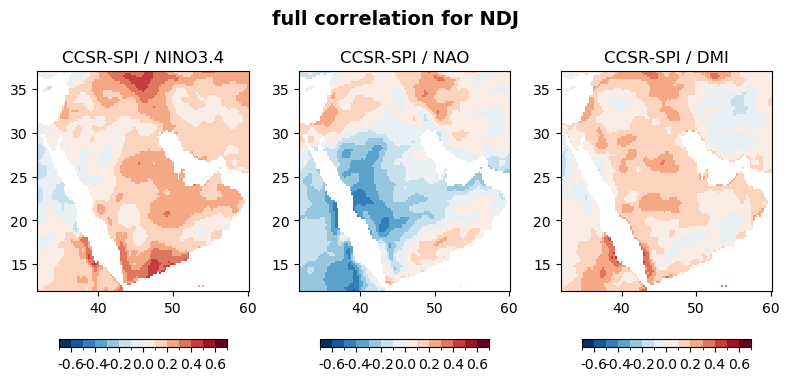

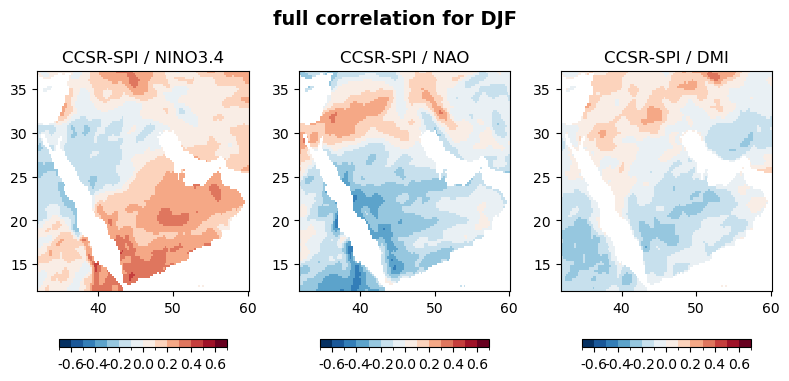

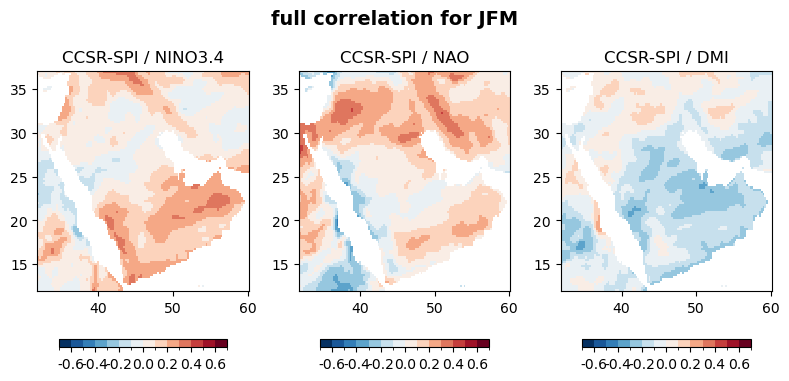

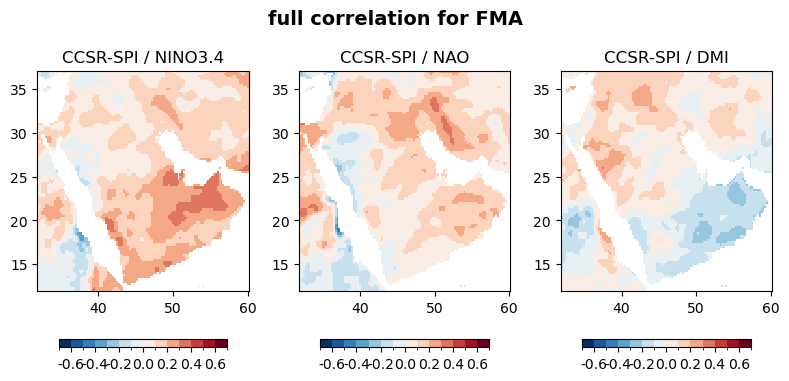

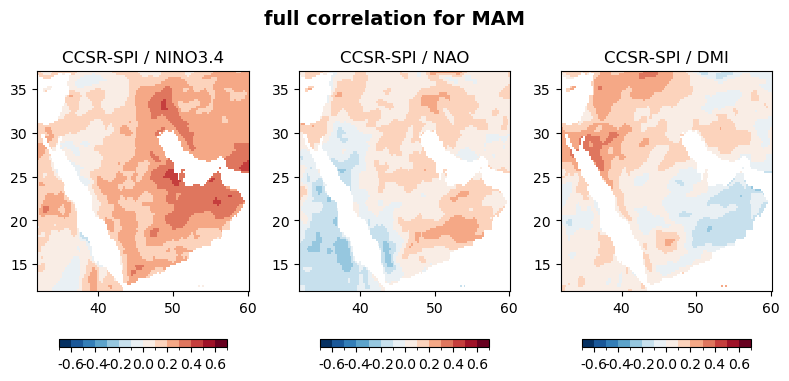

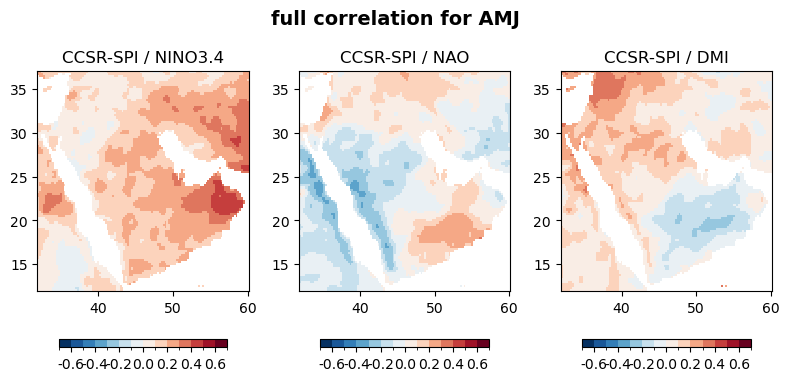

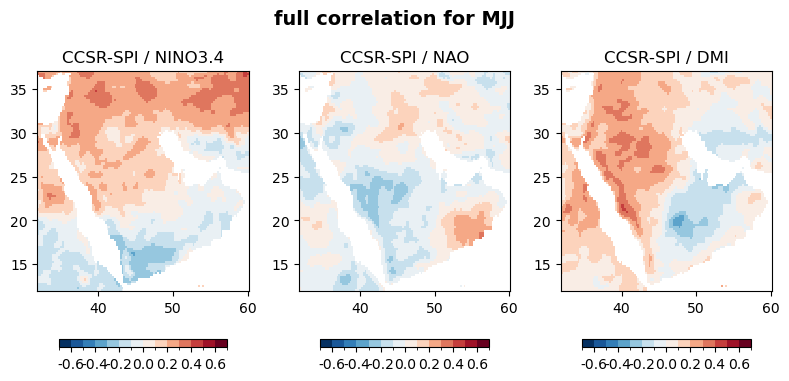

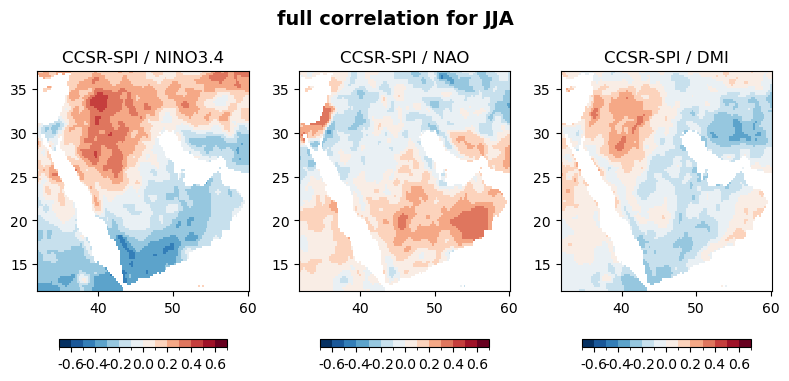

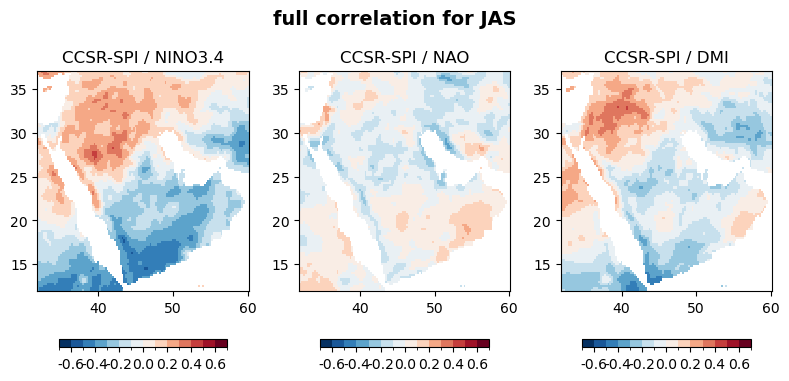

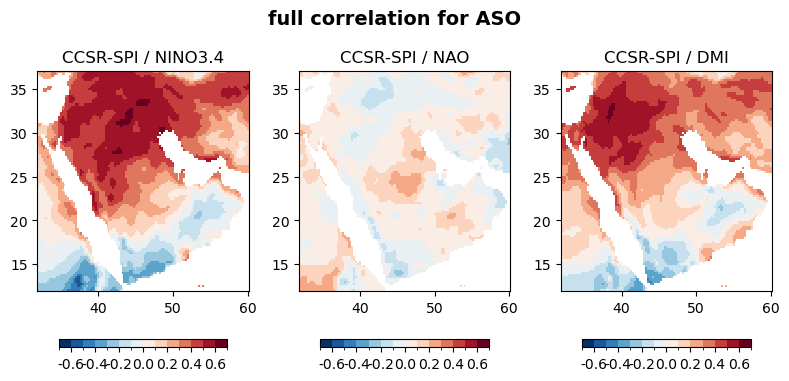

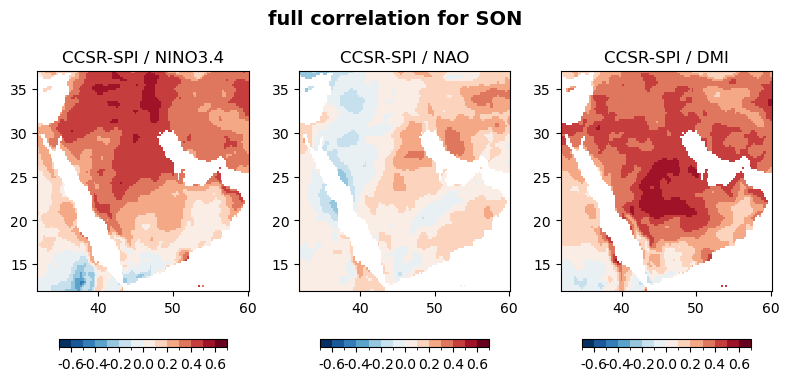

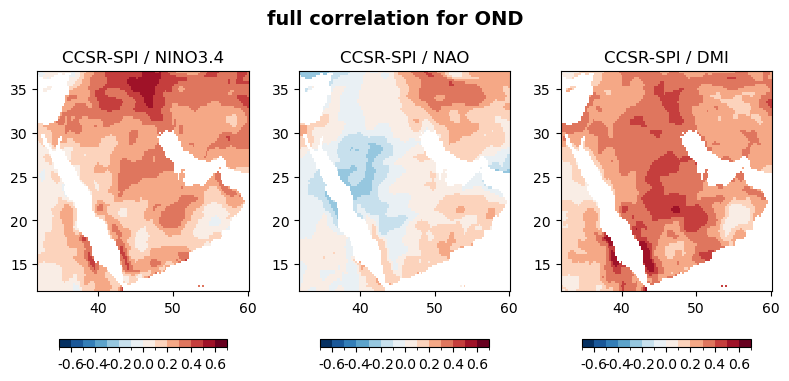

In [ ]:
corr_type = 'full'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'CCSR_SPI',corr_type=corr_type)
levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
vmin = -0.6
vmax = 0.6
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

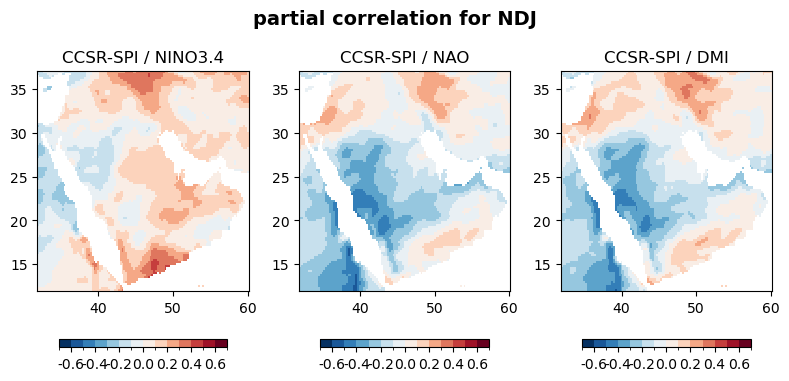

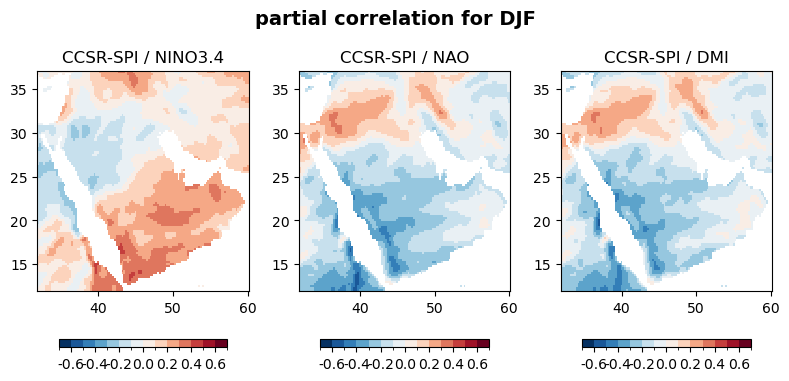

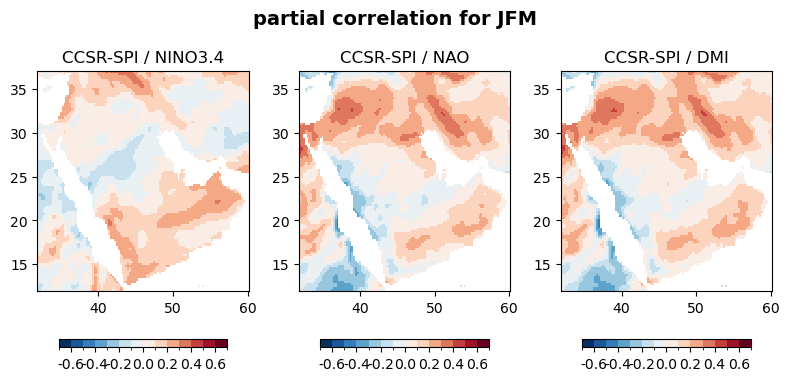

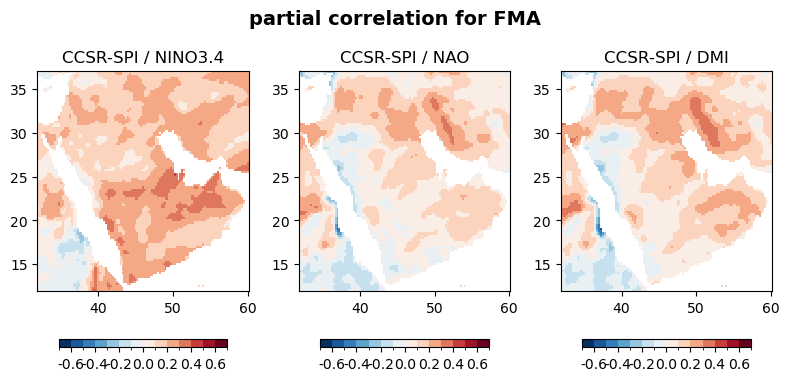

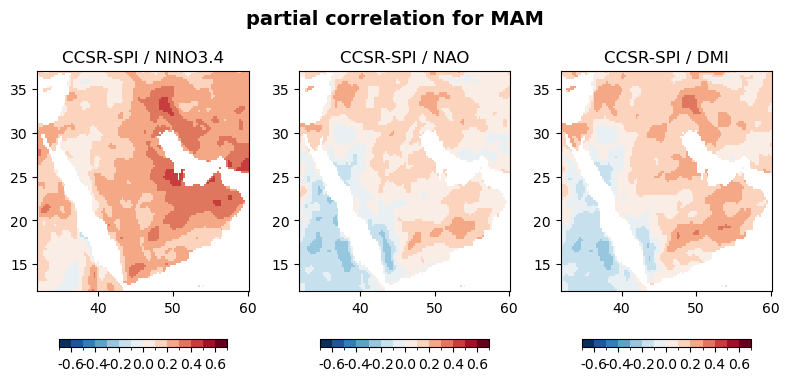

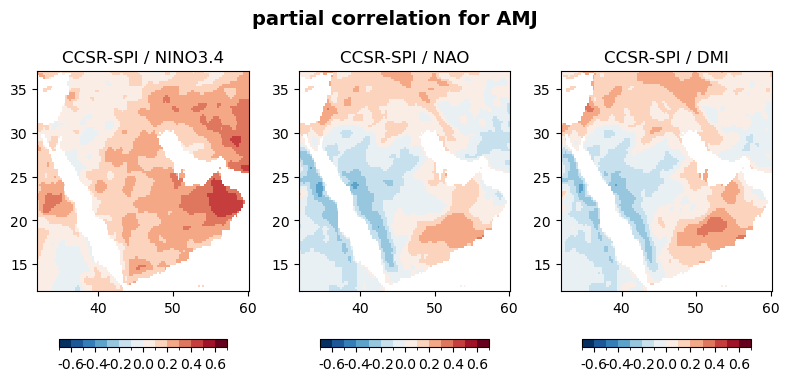

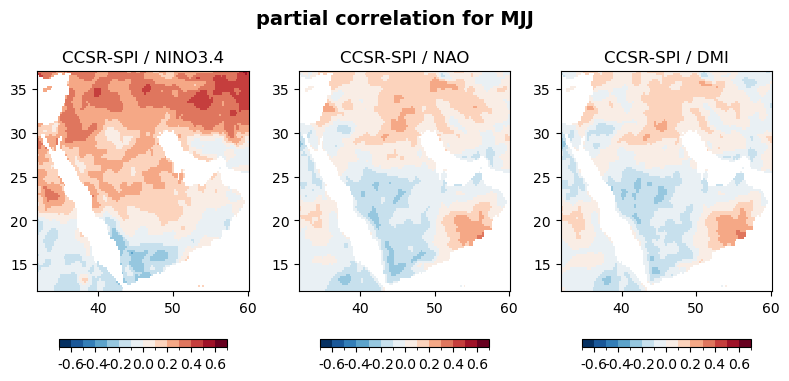

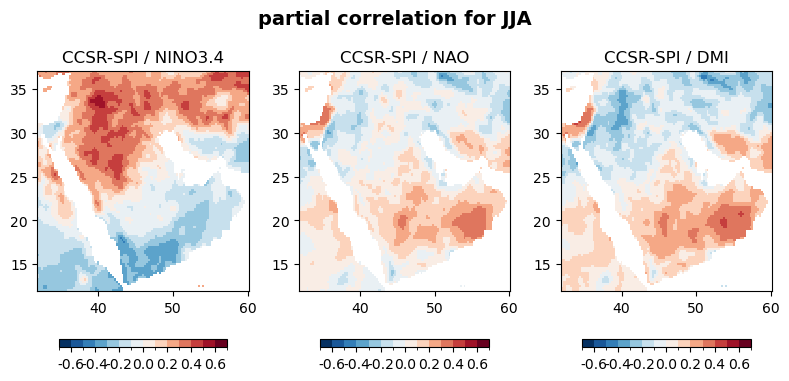

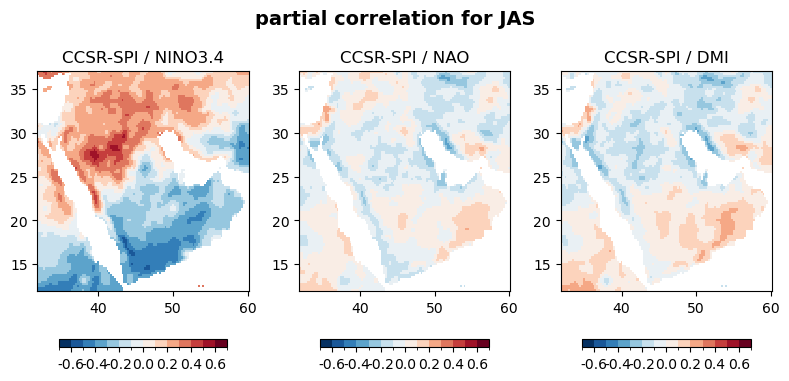

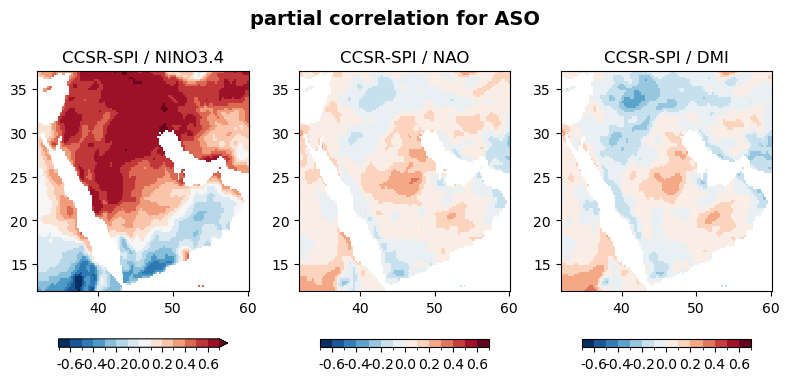

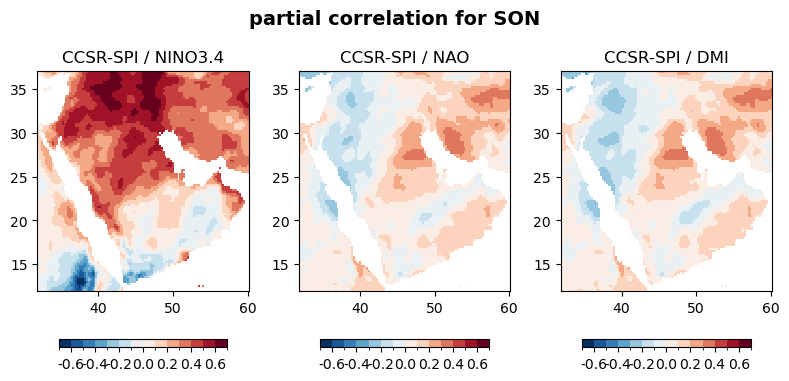

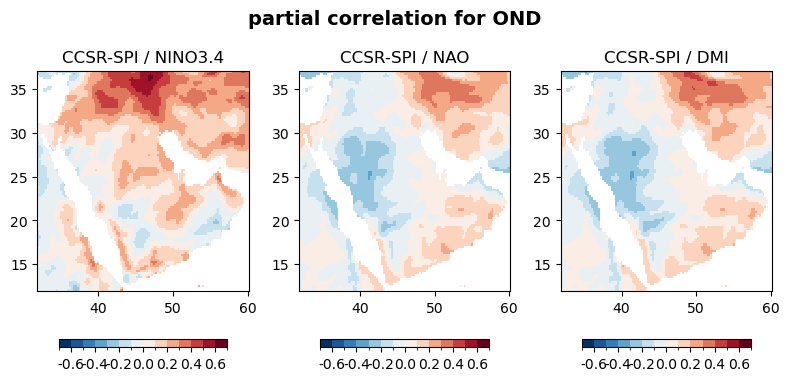

In [ ]:

corr_type = 'partial'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'CCSR_SPI',corr_type=corr_type)

levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

C:\Users\emile\AppData\Local\Temp\ipykernel_13680\1099121474.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


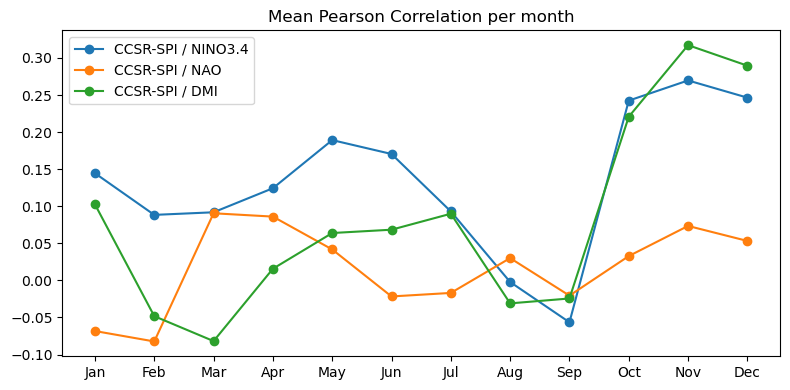

In [ ]:
corr_nino = np.zeros(12)
corr_nao = np.zeros(12)
corr_dmi = np.zeros(12)

months = np.arange(1, 13)

for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    corr_mat_nino = xr.corr(data_month['CCSR_SPI'], data_month['NINO'], dim='T')
    corr_mat_nao= xr.corr(data_month['CCSR_SPI'], data_month['NAO'], dim='T')
    corr_mat_dmi= xr.corr(data_month['CCSR_SPI'], data_month['DMI'], dim='T')
    #corr_mat_ccsr_nino = xr.corr(data_month['CCSR_SPI'], data_month['NINO'], dim='T')


    corr_nino[month-1] = xr.where(np.isinf(corr_mat_nino), np.nan, corr_mat_nino).mean()
    corr_nao[month-1] = xr.where(np.isinf(corr_mat_nao), np.nan, corr_mat_nao).mean()
    corr_dmi[month-1] = xr.where(np.isinf(corr_mat_dmi), np.nan, corr_mat_dmi).mean()
    #corr_ccsr_nino[month-1] = xr.where(np.isinf(corr_mat_ccsr_nino), np.nan, corr_mat_ccsr_nino).mean()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

#dataframe with correlation values
df = pd.DataFrame({'Month': months, 'CCSR-SPI / NINO3.4': corr_nino,
                     'CCSR-SPI / NAO': corr_nao, 'CCSR-SPI / DMI': corr_dmi})


#bar plot
#df.plot(x='Month', kind='bar', ax=ax)

# # Plot the correlation values
#ax.plot(months, corr_kaust_custom, label='KAUST-SPI / CCSR-SPI', marker='o')
ax.plot(months, corr_nino, label='CCSR-SPI / NINO3.4', marker='o')
ax.plot(months, corr_nao, label='CCSR-SPI / NAO', marker='o')
ax.plot(months, corr_dmi, label='CCSR-SPI / DMI', marker='o')

#ticks every month
ax.set_xticklabels(['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND'])
ax.set_xticks(months)
plt.legend()
plt.title('Mean Pearson Correlation per month')
plt.tight_layout()